# Exercise 9
Repeat exercise 11 of Part 2 (text classification with mostly linear classifiers), now using
an MLP classifier implemented (by you) in Keras/TensorFlow or PyTorch.
3 You may use
different features in the MLP classifier than the ones you used in exercise 11 of Part 2. Tune
the hyper-parameters (e.g., number of hidden layers, dropout probability) on the development
subset of your dataset. Monitor the performance of the MLP on the development subset
during training to decide how many epochs to use. Include experimental results of a baseline
majority classifier, as well as experimental results of your best classifier from exercise 11 of
Part 2, now treated as a second baseline. Include in your report:

• Curves showing the loss on training and development data as a function of epochs
(slide 49).

• Precision, recall, F1, precision-recall AUC scores, for each class and classifier,
separately for the training, development, and test subsets, as in exercise 11 of Part 2.

• Macro-averaged precision, recall, F1, precision-recall AUC scores (averaging the
corresponding scores of the previous bullet over the classes), for each classifier,
separately for the training, development, and test subsets, as in exercise 11 of Part 2.

• A short description of the methods and datasets you used, including statistics about
the datasets (e.g., average document length, number of training/dev/test documents,
vocabulary size) and a description of the preprocessing steps that you performed.
You may optionally wish to try ensembles. One possibility is to use k separate MLP
classifiers, corresponding to your k best checkpoints (k best epochs in terms of development
loss), and aggregate their decisions by majority voting. Another possibility is to use temporal
averaging, i.e., use a single MLP classifier, whose weights are the average of the weights of
the k best checkpoints.

## Mount Google Drive

To access files stored in Google Drive, we need to mount it in Google Colab.  
The drive will be mounted at `/content/drive`, allowing seamless file access.  

### Explanation:
- **Mounting Drive**: Connects your Google Drive to Colab.
- **Forced Remount**: Ensures that the drive is remounted if already mounted.
- **Use Cases**: Useful for loading datasets, saving models, and storing experiment results persistently.


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


## Import Required Libraries

This project utilizes various libraries for data processing, machine learning, and deep learning.

### **General Libraries**
- **matplotlib.pyplot, numpy, pandas**: Essential for data manipulation, visualization, and numerical operations.

### **PyTorch (Deep Learning)**
- **torch, torch.optim, torch.nn, torch.nn.functional**: Provides deep learning capabilities.
- **torch.utils.data**: Facilitates dataset handling and batching.
- **torch.device**: Checks for GPU availability to optimize training.

### **Scikit-learn (Machine Learning & Evaluation)**
- **DummyClassifier**: Baseline majority classifier for comparison.
- **LogisticRegression**: Traditional ML classifier for sentiment analysis.
- **train_test_split**: Splits dataset into training, development, and test sets.
- **TfidfVectorizer**: Converts text into TF-IDF features.
- **Metrics (precision, recall, F1, etc.)**: Used for performance evaluation.

### **Word Embeddings**
- **gensim.downloader**: Downloads pre-trained word embeddings (e.g., GloVe, Word2Vec).

### **NLP & Text Processing**
- **re (Regular Expressions)**: Used for text cleaning.
- **nltk & word_tokenize**: Tokenizes text into words.

### **Performance Optimization**
- **tqdm**: Displays progress bars for efficient iteration tracking.

### **Device Configuration**
- The script checks for GPU availability and assigns computations to `cuda` if available, otherwise defaults to `cpu`.

### **NLTK Data Download**
- Ensures necessary tokenization resources (`punkt`, `punkt_tab`) are available.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (
    precision_score, recall_score, f1_score, precision_recall_curve, auc,
    classification_report, accuracy_score
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api
import re
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

Using device: cuda


True

## Load and Merge Dataset

### **Dataset Information**
The dataset consists of two CSV files:  
- **Fake.csv**: Contains fake news articles.
- **True.csv**: Contains real news articles.

### **Loading Data**
- The datasets are read using **pandas `read_csv`** from Google Drive.
- Each dataset is stored as a DataFrame (`df_fake`, `df_true`).

### **Labeling Data**
- A **binary label** is assigned:
  - **Fake news** → Label `1`
  - **True news** → Label `0`

### **Merging Data**
- Both DataFrames are concatenated along axis `0` (rows), forming a combined dataset (`df_merge`).

### **Preview Data**
- The first 10 rows of `df_merge` are displayed to verify the data structure.


In [ ]:
df_fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text Analytics Assignment 2/Dataset/Fake.csv")
df_true = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text Analytics Assignment 2/Dataset/True.csv")


In [ ]:
df_fake["label"] = 1
df_true["label"] = 0

In [ ]:
df_merge = pd.concat([df_fake, df_true], axis =0 )
df_merge.head(10)

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   
5   Racist Alabama Cops Brutalize Black Boy While...   
6   Fresh Off The Golf Course, Trump Lashes Out A...   
7   Trump Said Some INSANELY Racist Stuff Inside ...   
8   Former CIA Director Slams Trump Over UN Bully...   
9   WATCH: Brand-New Pro-Trump Ad Features So Muc...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   
5  The number of cases of cops brutalizing and ki...    News   
6  Donald Trump spent a good portion of his day a...    News   
7  In the wake of yet another court decision that...    News   
8  Many people have raised the alarm regarding th...    News   
9  Just when you might have thought we d get a br...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 30, 2017      1  
3  December 29, 2017      1  
4  December 25, 2017      1  
5  December 25, 2017      1  
6  December 23, 2017      1  
7  December 23, 2017      1  
8  December 22, 2017      1  
9  December 21, 2017      1

## Data Preprocessing and Dataset Statistics

### **Removing Unnecessary Columns**
- The columns `title`, `subject`, and `date` are dropped as they are not relevant to the analysis.
- The index is reset, and the old index column is dropped.

### **Preprocessing Text**
A function is defined to preprocess text:
- **Lowercase conversion**: All text is converted to lowercase.
- **Removing numbers**: All digits are removed.
- **Punctuation removal**: Non-alphanumeric characters are discarded.
- **Tokenization**: The text is split into individual tokens (words) using NLTK’s `word_tokenize`.

### **Splitting Data**
The dataset is divided into:
- **Training set**: 80% of the data.
- **Validation set**: 10% of the data.
- **Test set**: 10% of the data.
- Stratified splitting ensures that each set maintains the proportion of fake and true news articles.

### **Checking Class Distribution**
The class distribution (number of fake vs. true news) is displayed for each data split.

### **Preprocessing All Splits**
The preprocessing function is applied to the text data in all splits (training, validation, test).

### **Dataset Statistics Function**
The function `dataset_stats_and_preprocessing` provides key statistics about the dataset:
- **Number of documents** in each set.
- **Average document length** (word count) in each set.
- **Vocabulary size**: Unique words across the entire corpus.
- **Preprocessing steps** description: Lists the transformations applied to the text.

The function also prints these statistics for the user to review.

### **Example Output**
The function outputs the following:
- Total number of documents.
- Distribution of fake and true news.
- Document counts for each split.
- Average document length for each split.
- Vocabulary size.


In [ ]:
#Removing columns which are not required¶
df = df_merge.drop(["title", "subject","date"], axis = 1)

df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)
df.head()

text  label
0  Donald Trump just couldn t wish all Americans ...      1
1  House Intelligence Committee Chairman Devin Nu...      1
2  On Friday, it was revealed that former Milwauk...      1
3  On Christmas day, Donald Trump announced that ...      1
4  Pope Francis used his annual Christmas Day mes...      1

In [ ]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize text
    return ' '.join(tokens)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target labels (y)
X = df['text'].values
y = df['label'].values

# Split into training, validation, and test sets with stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=2025, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2025, stratify=y_temp)

# Check the distribution of labels in each set
print("Training set class distribution:", np.bincount(y_train))
print("Validation set class distribution:", np.bincount(y_val))
print("Test set class distribution:", np.bincount(y_test))

Training set class distribution: [19275 21133]
Validation set class distribution: [1071 1174]
Test set class distribution: [1071 1174]


In [ ]:
 # Preprocess all splits
 X_train = [preprocess_text(text) for text in X_train]
 X_val = [preprocess_text(text) for text in X_val]
 X_test = [preprocess_text(text) for text in X_test]

In [ ]:
import numpy as np
from collections import Counter
import string

# Function to calculate dataset statistics and preprocessing steps
def dataset_stats_and_preprocessing(df, X_train, X_val, X_test):
    # Number of documents
    num_train = len(X_train)
    num_val = len(X_val)
    num_test = len(X_test)

    # Average document length (in terms of word count)
    avg_train_length = np.mean([len(doc.split()) for doc in X_train])
    avg_val_length = np.mean([len(doc.split()) for doc in X_val])
    avg_test_length = np.mean([len(doc.split()) for doc in X_test])

    # Vocabulary size (unique words in the whole corpus)
    all_text = ' '.join(df['text'].values)
    all_words = all_text.split()
    vocab_size = len(set(all_words))

    # Preprocessing steps description
    preprocessing_steps = """
    1. Text Tokenization: The text is split into words based on spaces. Punctuation is included as part of words (can be changed based on need).
    2. Stop-word Removal: If implemented, remove common words that don't carry useful information (e.g., "the", "and").
    3. Lowercasing: The text is converted to lowercase to ensure uniformity.
    """

    # Displaying the calculated statistics
    print(f"Total documents: {len(df)}")
    print(f"Fake news: {len(df[df['label'] == 1])}, True news: {len(df[df['label'] == 0])}")
    print(f"Number of training documents: {num_train}")
    print(f"Number of validation documents: {num_val}")
    print(f"Number of test documents: {num_test}")
    print(f"Average document length in training set (in words): {round(avg_train_length)}")
    print(f"Average document length in validation set (in words): {round(avg_val_length)}")
    print(f"Average document length in test set (in words): {round(avg_test_length)}")
    print(f"Vocabulary size (unique words): {vocab_size}")


    return {
        "num_train": num_train,
        "num_val": num_val,
        "num_test": num_test,
        "avg_train_length": avg_train_length,
        "avg_val_length": avg_val_length,
        "avg_test_length": avg_test_length,
        "vocab_size": vocab_size,
        "preprocessing_steps": preprocessing_steps
    }

# Example usage:
# Assuming df is your dataframe containing the text and labels
dataset_info = dataset_stats_and_preprocessing(df, X_train, X_val, X_test)


Total documents: 44898
Fake news: 23481, True news: 21417
Number of training documents: 40408
Number of validation documents: 2245
Number of test documents: 2245
Average document length in training set (in words): 399
Average document length in validation set (in words): 408
Average document length in test set (in words): 402
Vocabulary size (unique words): 397481


## MLP Model Definition

The **MLP (Multilayer Perceptron)** model is a fully connected neural network used for binary classification.

### **Model Structure**
- The model consists of an input layer, multiple hidden layers, and an output layer.
- Each hidden layer includes:
  - **Linear layer**: Applies a linear transformation (i.e., weighted sum of inputs).
  - **Batch Normalization** (optional): Normalizes the outputs of each hidden layer to improve training stability.
  - **ReLU Activation**: Adds non-linearity, allowing the network to learn more complex patterns.
  - **Dropout** (optional): Randomly drops a fraction of units during training to prevent overfitting.
- The output layer has one unit, which is used for binary classification (fake vs. true news). The output is passed through a **sigmoid activation function** to produce a probability value between 0 and 1.

### **Class Parameters:**
- **`input_dim`**: Number of features in the input.
- **`hidden_dims`**: List defining the number of units in each hidden layer.
- **`dropout`**: Probability of dropout to prevent overfitting (default is 0.0).
- **`batch_norm`**: Boolean flag to include batch normalization (default is False).

### **Forward Pass**
- The `forward` method takes an input tensor `x`, passes it through the defined network layers, and applies the sigmoid activation to the output layer to obtain probabilities.

This architecture is suitable for tasks like binary text classification, such as determining whether news articles are fake or true.


In [ ]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout=0.0, batch_norm=False):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            if batch_norm:
                layers.append(nn.BatchNorm1d(dim))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 1))  # Output layer for binary classification
        self.network = nn.Sequential(*layers)

    def forward(self, x):
      logits = self.network(x)
      return torch.sigmoid(logits)

## MLP Prediction Function

This function uses the trained MLP model to make predictions on a given dataset.

### **Function Overview**
The `predict_mlp` function:
- Sets the model in **evaluation mode** (`model.eval()`) to disable certain features like dropout.
- Iterates over the `data_loader` to process input data in batches.
- Moves each batch of inputs to the appropriate device (CPU or GPU) using `inputs.to(device)`.
- Feeds the inputs through the model to get the outputs.
- Applies the **sigmoid function** to convert the raw model outputs into probabilities between 0 and 1.
- Collects the predictions and returns them as a flattened numpy array.

### **Parameters:**
- **`model`**: The trained MLP model.
- **`data_loader`**: DataLoader containing the input data in batches.
- **`device`**: The device to run the model on (either "cuda" for GPU or "cpu").

### **Output:**
- A numpy array of predicted probabilities for each sample, where values close to 1 indicate a higher likelihood of the positive class (fake news in this case).


In [ ]:
# Function to predict using MLP
def predict_mlp(model, data_loader, device):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_pred.extend(torch.sigmoid(outputs).cpu().numpy())
    return np.array(y_pred).flatten()

## Word Embeddings for Text Features

### **Embedding Models**
The following pre-trained word embedding models are used:
- **Word2Vec (Google News)**: Trained on Google News dataset, providing 300-dimensional word vectors.
- **GloVe (Wikipedia + Gigaword)**: Trained on a combination of Wikipedia and the Gigaword dataset, also providing 300-dimensional word vectors.

### **Loading Embeddings**
The embeddings are loaded using the **gensim API**:
- The `load_embeddings` function loads the specified pre-trained model (either Word2Vec or GloVe) from the gensim API.

### **Word2Vec Features Extraction**
- **Function**: `get_word2vec_features`
- **Process**:
  - For each text in the dataset, it is tokenized into words.
  - Each word is converted into a 300-dimensional vector using the **Word2Vec model**.
  - The vectors for all words in the text are averaged to get a single feature vector for that text.
  - If no word from the text exists in the model's vocabulary, a zero vector of size 300 is used.

### **GloVe Features Extraction**
- **Function**: `get_glove_features`
- **Process**: Similar to Word2Vec, but uses the **GloVe model** for word embeddings.

### **Training Set Features Extraction**
- The **Word2Vec** and **GloVe** embeddings are applied to the training data (`X_train`), generating feature matrices:
  - `word2vec_train_features`: Contains the averaged Word2Vec vectors for each training sample.
  - `glove_train_features`: Contains the averaged GloVe vectors for each training sample.

These feature matrices can then be used as input for further model training or evaluation.


In [ ]:
import gensim.downloader as api
import numpy as np

# Load pre-trained embeddings from gensim API
def load_embeddings(embedding_name):
    print(f"Loading {embedding_name} embeddings...")
    model = api.load(embedding_name)  # Loads the model from the API
    return model

# Functions to get embeddings
def get_word2vec_features(texts, model, vector_size=300):
    features = []
    for text in texts:
        tokens = text.split()  # Tokenize the text into words
        word_vectors = [model[token] for token in tokens if token in model.key_to_index]
        if word_vectors:
            features.append(np.mean(word_vectors, axis=0))  # Average the word vectors
        else:
            features.append(np.zeros(vector_size))  # If no words found, append a zero vector
    return np.array(features)

def get_glove_features(texts, model, vector_size=300):
    features = []
    for text in texts:
        tokens = text.split()  # Tokenize the text into words
        word_vectors = [model[token] for token in tokens if token in model.key_to_index]
        if word_vectors:
            features.append(np.mean(word_vectors, axis=0))  # Average the word vectors
        else:
            features.append(np.zeros(vector_size))  # If no words found, append a zero vector
    return np.array(features)



word2vec_model = load_embeddings("word2vec-google-news-300")
glove_model = load_embeddings("glove-wiki-gigaword-300")


word2vec_train_features = get_word2vec_features(X_train, word2vec_model)
glove_train_features = get_glove_features(X_train, glove_model)


Loading word2vec-google-news-300 embeddings...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Loading glove-wiki-gigaword-300 embeddings...
[==================================================] 100.0% 376.1/376.1MB downloaded


## Plotting Loss Curves for Multiple Models and Representations

### **Purpose**
The `plot_loss_curves` function visualizes the training and validation loss curves for multiple models and representations over multiple epochs. This is helpful in comparing the performance of different models and embeddings (such as TF-IDF, Word2Vec, and GloVe).

### **Parameters:**
- **`results`**: A dictionary containing loss data for each model and representation combination. The dictionary should have the following structure:
  - Keys: Model and representation names, e.g., `"Simple Deep MLP (TF-IDF)"`.
  - Values: A dictionary with keys `"train_losses"` and `"val_losses"`, each containing a list of losses over the epochs.

### **Process:**
- **Models**: The function considers three models ("Simple Deep MLP", "Wide MLP", and "Wide & Deep MLP"). You can modify the list to match the actual models in your results.
- **Representations**: The function also evaluates three representations ("TF-IDF", "Word2Vec", and "GloVe"), which can be adjusted based on your use case.
- **Subplots**: For each combination of model and representation, the function creates a subplot that shows:
  - **Training Loss** (solid blue line).
  - **Validation Loss** (dashed orange line).
  - **Annotations**: Each point on the curves is annotated with its respective loss value for clarity.
  - **Y-Axis Customization**: The y-axis ticks are set to show the min, midpoint, and max loss values for better readability.

### **Output:**
- **Visualized Curves**: The function generates a grid of plots showing the loss curves for each model and representation. Each plot displays the corresponding loss values for training and validation across epochs.



In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    models = ["Simple Deep MLP", "Wide MLP", "Wide & Deep MLP"]  # Adjust model names if needed
    representations = ["TF-IDF", "Word2Vec", "GloVe"]

    fig, axes = plt.subplots(len(representations), len(models), figsize=(18, 9))
    axes = axes.flatten()

    for row, rep_name in enumerate(representations):
        for col, model_name in enumerate(models):
            ax_idx = row * len(models) + col
            ax = axes[ax_idx]
            model_key = f"{model_name} ({rep_name})"

            if model_key in results:
                train_losses = results[model_key].get("train_losses", [])
                val_losses = results[model_key].get("val_losses", [])

                if train_losses and val_losses:
                    # Plot train losses
                    train_line, = ax.plot(train_losses, label="Train Loss", linestyle='-', color='blue', marker='o')
                    # Plot validation losses
                    val_line, = ax.plot(val_losses, label="Val Loss", linestyle='--', color='orange', marker='s')

                    # Annotate each point on the train loss curve
                    for i, (x, y) in enumerate(zip(range(len(train_losses)), train_losses)):
                        ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='blue')

                    # Annotate each point on the validation loss curve
                    for i, (x, y) in enumerate(zip(range(len(val_losses)), val_losses)):
                        ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color='orange')

                    ax.set_title(f"{model_name} ({rep_name}) Loss")
                    ax.set_xlabel("Epochs")
                    ax.set_ylabel("Loss")
                    ax.legend()

                    # Set custom y-axis ticks
                    min_loss = min(min(train_losses), min(val_losses))
                    max_loss = max(max(train_losses), max(val_losses))
                    y_ticks = [min_loss, (min_loss + max_loss) / 2, max_loss]  # Example: min, mid, max loss
                    ax.set_yticks(y_ticks)
                    ax.set_yticklabels([f"{tick:.3f}" for tick in y_ticks])  # Format ticks to 2 decimal places
                else:
                    ax.set_title(f"{model_name} ({rep_name}) - No Loss Data")
            else:
                ax.set_title(f"{model_name} ({rep_name}) - Not Found")

    plt.tight_layout()
    plt.show()

## EarlyStopping Class

### **Purpose**
The `EarlyStopping` class helps prevent overfitting by stopping the training process early if the model's validation loss stops improving for a set number of epochs (defined by `patience`). It is commonly used in training neural networks to avoid wasting resources on unnecessary epochs when further improvements in the model's performance are unlikely.

### **Parameters:**
- **`patience`**: The number of epochs to wait for improvement in the validation loss before stopping training. Default is 5.
- **`delta`**: The minimum change in validation loss to qualify as an improvement. If the change is smaller than `delta`, it is considered as no improvement. Default is 0.

### **Attributes:**
- **`best_loss`**: Stores the best (lowest) validation loss observed so far.
- **`counter`**: Tracks the number of epochs without improvement in validation loss.
- **`stop_training`**: Boolean flag indicating whether training should stop.

### **Methods:**
- **`__call__(self, val_loss)`**: This method is called at the end of each epoch with the current validation loss (`val_loss`).
  - If the `best_loss` is `None`, it sets it to the first observed `val_loss`.
  - If the current `val_loss` is not better than the `best_loss - delta`, it increments the counter.
  - If the counter exceeds the `patience` value, it sets `stop_training` to `True`, signaling the training process to halt.
  - If the current `val_loss` is better, it resets the counter and updates `best_loss`.

In [ ]:
# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True
        else:
            self.best_loss = val_loss
            self.counter = 0

## Model Training and Evaluation with Different Text Representations

The following code provides a comprehensive framework for training and evaluating multiple models using various text representations like TF-IDF, Word2Vec, and GloVe. The models include:
- **Dummy Majority Classifier**
- **Logistic Regression**
- **Multiple MLP (Multi-Layer Perceptron) models** with different architectures.

### **1. Text Representations**
Three types of text representations are used in the model:
- **TF-IDF**: This uses `TfidfVectorizer` from `sklearn` to extract important features from the text.
- **Word2Vec**: Pre-trained embeddings from `word2vec-google-news-300` are used to convert words into vectors.
- **GloVe**: Pre-trained embeddings from `glove-wiki-gigaword-300` are used for word vectorization.

### **2. MLP Models**
Three types of MLP models with varying complexities are defined:
- **Simple Deep MLP**: A basic MLP with 3 hidden layers.
- **Wide MLP**: A more complex MLP with a wider architecture.
- **Wide & Deep MLP**: A model with both a wider architecture and additional regularization (dropout and batch normalization).

### **3. Training Procedure**
The training loop iterates through each representation and model:
- For **MLP models**, the loss function used is `BCEWithLogitsLoss` (Binary Cross Entropy with Logits), and the optimizer is `Adam`. Early stopping is applied to prevent overfitting.
- **Dummy Majority Classifier** and **Logistic Regression** are used as baselines for comparison.
  
### **4. Evaluation Metrics**
The following evaluation metrics are calculated:
- **Precision-Recall AUC**: Calculated for each model to evaluate performance in terms of precision and recall.
- **Classification Reports**: Includes precision, recall, F1 score, and support for both classes (True News and Fake News).

### **5. Results**
The results are stored in a dictionary and displayed after training. Each model's:
- Classification reports (for training, validation, and test sets)
- Precision-Recall AUC scores for training, validation, and test sets are printed.

### **Suggestions for Improvement**
1. **Handling Imbalanced Data**: You can apply class weights in models like logistic regression or MLP to address class imbalance.
2. **Model Checkpointing**: Consider saving the best model based on validation performance to avoid overfitting.
3. **Hyperparameter Tuning**: Experiment with tuning hyperparameters like learning rate and layer sizes for the MLP models.
4. **Early Stopping Optimization**: Ensure that the `EarlyStopping` class is functioning as intended, resetting the counter on improvements.




In [ ]:
from sklearn.metrics import precision_recall_curve, auc, classification_report, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn

# Define representations
representations = {"TF-IDF": "tfidf", "Word2Vec": "embeddings", "GloVe": "glove"}

# Define target class names
target_names = ['True News', 'Fake News']

# Store results
results = {}

# Iterate over each representation
for rep_name, rep_type in representations.items():
    print(f"\nUsing {rep_name} representation...")
    print("=" * 50)

    # Vectorization for TF-IDF (example)
    if rep_type == "tfidf":
        from sklearn.feature_extraction.text import TfidfVectorizer
        vectorizer = TfidfVectorizer(max_features=5000)
        X_train_rep = vectorizer.fit_transform(X_train).toarray()
        X_val_rep = vectorizer.transform(X_val).toarray()
        X_test_rep = vectorizer.transform(X_test).toarray()
    elif rep_type == "embeddings":
        # Use pre-trained Word2Vec embeddings
        model = api.load("word2vec-google-news-300")
        X_train_rep = get_word2vec_features(X_train, model)
        X_val_rep = get_word2vec_features(X_val, model)
        X_test_rep = get_word2vec_features(X_test, model)
    elif rep_type == "glove":
        # Use pre-trained GloVe embeddings
        model = api.load("glove-wiki-gigaword-300")
        X_train_rep = get_glove_features(X_train, model)
        X_val_rep = get_glove_features(X_val, model)
        X_test_rep = get_glove_features(X_test, model)

    # Ensure the features are in the right format
    X_train_rep = np.array(X_train_rep)
    X_val_rep = np.array(X_val_rep)
    X_test_rep = np.array(X_test_rep)

    # Prepare DataLoader (move to CUDA)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_dataset = TensorDataset(torch.FloatTensor(X_train_rep).to(device), torch.FloatTensor(y_train).to(device))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_rep).to(device), torch.FloatTensor(y_val).to(device))
    test_dataset = TensorDataset(torch.FloatTensor(X_test_rep).to(device), torch.FloatTensor(y_test).to(device))

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_loader = DataLoader(test_dataset, batch_size=64)

    input_dim = X_train_rep.shape[1]  # Input size for the MLP models

    # Define models
    models_config = {
        "Dummy Majority": DummyClassifier(strategy="most_frequent"),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Simple Deep MLP": MLP(input_dim, [512, 256, 128]).to(device),
        "Wide MLP": MLP(input_dim, [1024, 512, 256, 128]).to(device),
        "Wide & Deep MLP": MLP(input_dim, [2048, 1024, 512, 256, 128], dropout=0.5,batch_norm=True).to(device)
    }

    # Train and evaluate models for each representation
    for model_name, model in models_config.items():
        model_key = f"{model_name} ({rep_name})"
        print(f"Training {model_key}...")
        print("=" * 50)

        if isinstance(model, nn.Module):  # MLP Models
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
            train_losses, val_losses = [], []
            train_accuracies, val_accuracies = [], []

            # Initialize EarlyStopping
            early_stopping = EarlyStopping(patience=5)

            for epoch in tqdm(range(40), desc=f"Epochs for {model_key}", ncols=100):
                model.train()
                epoch_train_loss = 0.0
                epoch_train_correct = 0
                epoch_train_total = 0

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    labels = labels.unsqueeze(1).float()  # Reshape labels to [batch_size, 1] and convert to float
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    epoch_train_loss += loss.item()
                    predicted = torch.round(torch.sigmoid(outputs))
                    epoch_train_correct += (predicted == labels).sum().item()
                    epoch_train_total += labels.size(0)

                # Calculate training accuracy
                train_accuracy = epoch_train_correct / epoch_train_total
                train_accuracies.append(train_accuracy)

                # Validation loss and accuracy
                model.eval()
                epoch_val_loss = 0.0
                epoch_val_correct = 0
                epoch_val_total = 0

                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        labels = labels.unsqueeze(1).float()  # Reshape labels to [batch_size, 1] and convert to float
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        epoch_val_loss += loss.item()

                        predicted = torch.round(torch.sigmoid(outputs))
                        epoch_val_correct += (predicted == labels).sum().item()
                        epoch_val_total += labels.size(0)

                # Calculate validation accuracy
                val_accuracy = epoch_val_correct / epoch_val_total
                val_accuracies.append(val_accuracy)

                # Record losses
                train_losses.append(epoch_train_loss / len(train_loader))
                val_losses.append(epoch_val_loss / len(val_loader))

                # Print epoch results
                print(f"Epoch {epoch + 1}/{40}")
                print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}")
                print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")

                # Early stopping check
                early_stopping(epoch_val_loss / len(val_loader))

                if early_stopping.stop_training:
                    print("\nEarly stopping triggered")
                    break

                scheduler.step()  # Step the learning rate scheduler

            # Store predictions for Precision-Recall AUC calculation
            y_train_pred = predict_mlp(model, train_loader, device)
            y_val_pred = predict_mlp(model, val_loader, device)
            y_test_pred = predict_mlp(model, test_loader, device)

            # Compute Precision-Recall AUC
            precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred)
            pr_auc_train = auc(recall_train, precision_train)

            precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred)
            pr_auc_val = auc(recall_val, precision_val)

            precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred)
            pr_auc_test = auc(recall_test, precision_test)

            # Classification reports
            train_report = classification_report(y_train, y_train_pred > 0.5, target_names=target_names, zero_division=1)
            val_report = classification_report(y_val, y_val_pred > 0.5, target_names=target_names, zero_division=1)
            test_report = classification_report(y_test, y_test_pred > 0.5, target_names=target_names, zero_division=1)

            # Store results
            results[model_key] = {
                "train_losses": train_losses,
                "val_losses": val_losses,
                "train_accuracies": train_accuracies,
                "val_accuracies": val_accuracies,
                "metrics": {
                    "train_report": train_report,
                    "val_report": val_report,
                    "test_report": test_report,
                    "pr_auc": {
                        "train_pr_auc": pr_auc_train,
                        "val_pr_auc": pr_auc_val,
                        "test_pr_auc": pr_auc_test
                    }
                }
            }
        else:  # Dummy and Logistic Regression
            model.fit(X_train_rep, y_train)
            y_pred = model.predict_proba(X_test_rep)[:, 1]  # Use probability scores for PR AUC

            # Compute Precision-Recall AUC
            precision_train, recall_train, _ = precision_recall_curve(y_train, model.predict_proba(X_train_rep)[:, 1])
            pr_auc_train = auc(recall_train, precision_train)

            precision_val, recall_val, _ = precision_recall_curve(y_val, model.predict_proba(X_val_rep)[:, 1])
            pr_auc_val = auc(recall_val, precision_val)

            precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred)
            pr_auc_test = auc(recall_test, precision_test)

            # Classification reports
            train_report = classification_report(y_train, model.predict(X_train_rep), target_names=target_names, zero_division=1)
            val_report = classification_report(y_val, model.predict(X_val_rep), target_names=target_names, zero_division=1)
            test_report = classification_report(y_test, model.predict(X_test_rep), target_names=target_names, zero_division=1)

            # Store results
            results[model_key] = {
                "train_losses": None,
                "val_losses": None,
                "train_accuracies": None,
                "val_accuracies": None,
                "metrics": {
                    "train_report": train_report,
                    "val_report": val_report,
                    "test_report": test_report,
                    "pr_auc": {
                        "train_pr_auc": pr_auc_train,
                        "val_pr_auc": pr_auc_val,
                        "test_pr_auc": pr_auc_test
                    }
                }
            }

    # Print results for each model within the current representation
    print(f"\nResults for {rep_name} representation:")
    print("=" * 50)
    for model_key, result in results.items():
        if rep_name in model_key:
            print(f"\n{model_key} Classification Reports:")
            print("Training Report:")
            print(result["metrics"]["train_report"])
            print("Validation Report:")
            print(result["metrics"]["val_report"])
            print("Test Report:")
            print(result["metrics"]["test_report"])

            print("\nPrecision-Recall AUC Scores:")
            print(f"Training PR AUC: {result['metrics']['pr_auc']['train_pr_auc']:.4f}")
            print(f"Validation PR AUC: {result['metrics']['pr_auc']['val_pr_auc']:.4f}")
            print(f"Test PR AUC: {result['metrics']['pr_auc']['test_pr_auc']:.4f}")


Using TF-IDF representation...
Training Dummy Majority (TF-IDF)...
Training Logistic Regression (TF-IDF)...
Training Simple Deep MLP (TF-IDF)...


Epoch 1/40
Train Loss: 0.5126, Train Accuracy: 0.8683
Val Loss: 0.5016, Val Accuracy: 0.9817


Epoch 2/40
Train Loss: 0.5003, Train Accuracy: 0.9732
Val Loss: 0.5013, Val Accuracy: 0.9586


Epoch 3/40
Train Loss: 0.4991, Train Accuracy: 0.9802
Val Loss: 0.4966, Val Accuracy: 0.9862


Epoch 4/40
Train Loss: 0.4990, Train Accuracy: 0.9837
Val Loss: 0.4981, Val Accuracy: 0.9782


Epoch 5/40
Train Loss: 0.4986, Train Accuracy: 0.9879
Val Loss: 0.4971, Val Accuracy: 0.9884


Epoch 6/40
Train Loss: 0.4974, Train Accuracy: 0.9889
Val Loss: 0.4977, Val Accuracy: 0.9906


Epoch 7/40
Train Loss: 0.4972, Train Accuracy: 0.9877
Val Loss: 0.4963, Val Accuracy: 0.9889


Epoch 8/40
Train Loss: 0.4969, Train Accuracy: 0.9921
Val Loss: 0.4956, Val Accuracy: 0.9831


Epoch 9/40
Train Loss: 0.4967, Train Accuracy: 0.9924
Val Loss: 0.4956, Val Accuracy: 0.9849


Epoch 10/40
Train Loss: 0.4966, Train Accuracy: 0.9922
Val Loss: 0.4954, Val Accuracy: 0.9898


Epoch 11/40
Train Loss: 0.4962, Train Accuracy: 0.9935
Val Loss: 0.4953, Val Accuracy: 0.9889


Epoch 12/40
Train Loss: 0.4961, Train Accuracy: 0.9926
Val Loss: 0.4954, Val Accuracy: 0.9849


Epoch 13/40
Train Loss: 0.4960, Train Accuracy: 0.9935
Val Loss: 0.4951, Val Accuracy: 0.9884


Epoch 14/40
Train Loss: 0.4961, Train Accuracy: 0.9915
Val Loss: 0.4952, Val Accuracy: 0.9902


Epoch 15/40
Train Loss: 0.4960, Train Accuracy: 0.9940
Val Loss: 0.4951, Val Accuracy: 0.9866


Epoch 16/40
Train Loss: 0.4959, Train Accuracy: 0.9952
Val Loss: 0.4950, Val Accuracy: 0.9884


Epoch 17/40
Train Loss: 0.4959, Train Accuracy: 0.9954
Val Loss: 0.4950, Val Accuracy: 0.9875


Epoch 18/40
Train Loss: 0.4959, Train Accuracy: 0.9954
Val Loss: 0.4950, Val Accuracy: 0.9871


Epoch 19/40
Train Loss: 0.4959, Train Accuracy: 0.9956
Val Loss: 0.4952, Val Accuracy: 0.9924


Epoch 20/40
Train Loss: 0.4958, Train Accuracy: 0.9959
Val Loss: 0.4951, Val Accuracy: 0.9884


Epoch 21/40
Train Loss: 0.4958, Train Accuracy: 0.9957
Val Loss: 0.4951, Val Accuracy: 0.9884


Epoch 22/40
Train Loss: 0.4958, Train Accuracy: 0.9957
Val Loss: 0.4951, Val Accuracy: 0.9884

Early stopping triggered


Training Wide MLP (TF-IDF)...


Epoch 1/40
Train Loss: 0.5157, Train Accuracy: 0.9390
Val Loss: 0.5003, Val Accuracy: 0.9759


Epoch 2/40
Train Loss: 0.5043, Train Accuracy: 0.9764
Val Loss: 0.5021, Val Accuracy: 0.9822


Epoch 3/40
Train Loss: 0.5033, Train Accuracy: 0.9807
Val Loss: 0.5012, Val Accuracy: 0.9840


Epoch 4/40
Train Loss: 0.5018, Train Accuracy: 0.9734
Val Loss: 0.4983, Val Accuracy: 0.9875


Epoch 5/40
Train Loss: 0.5011, Train Accuracy: 0.9853
Val Loss: 0.5039, Val Accuracy: 0.9795


Epoch 6/40
Train Loss: 0.5002, Train Accuracy: 0.9881
Val Loss: 0.4993, Val Accuracy: 0.9862


Epoch 7/40
Train Loss: 0.4991, Train Accuracy: 0.9887
Val Loss: 0.4975, Val Accuracy: 0.9880


Epoch 8/40
Train Loss: 0.4982, Train Accuracy: 0.9911
Val Loss: 0.4991, Val Accuracy: 0.9893


Epoch 9/40
Train Loss: 0.4980, Train Accuracy: 0.9863
Val Loss: 0.4964, Val Accuracy: 0.9884


Epoch 10/40
Train Loss: 0.4974, Train Accuracy: 0.9911
Val Loss: 0.4965, Val Accuracy: 0.9875


Epoch 11/40
Train Loss: 0.4971, Train Accuracy: 0.9902
Val Loss: 0.4959, Val Accuracy: 0.9906


Epoch 12/40
Train Loss: 0.4969, Train Accuracy: 0.9929
Val Loss: 0.4958, Val Accuracy: 0.9893


Epoch 13/40
Train Loss: 0.4968, Train Accuracy: 0.9945
Val Loss: 0.4955, Val Accuracy: 0.9906


Epoch 14/40
Train Loss: 0.4967, Train Accuracy: 0.9929
Val Loss: 0.4958, Val Accuracy: 0.9911


Epoch 15/40
Train Loss: 0.4966, Train Accuracy: 0.9942
Val Loss: 0.4955, Val Accuracy: 0.9920


Epoch 16/40
Train Loss: 0.4967, Train Accuracy: 0.9950
Val Loss: 0.4956, Val Accuracy: 0.9911


Epoch 17/40
Train Loss: 0.4966, Train Accuracy: 0.9944
Val Loss: 0.4962, Val Accuracy: 0.9906


Epoch 18/40
Train Loss: 0.4967, Train Accuracy: 0.9951
Val Loss: 0.4958, Val Accuracy: 0.9906

Early stopping triggered


Training Wide & Deep MLP (TF-IDF)...


Epoch 1/40
Train Loss: 0.5143, Train Accuracy: 0.5232
Val Loss: 0.5014, Val Accuracy: 0.5229


Epoch 2/40
Train Loss: 0.5032, Train Accuracy: 0.5278
Val Loss: 0.5008, Val Accuracy: 0.5229


Epoch 3/40
Train Loss: 0.5018, Train Accuracy: 0.5438
Val Loss: 0.4985, Val Accuracy: 0.5626


Epoch 4/40
Train Loss: 0.5004, Train Accuracy: 0.5738
Val Loss: 0.4975, Val Accuracy: 0.5746


Epoch 5/40
Train Loss: 0.5004, Train Accuracy: 0.6081
Val Loss: 0.4991, Val Accuracy: 0.5336


Epoch 6/40
Train Loss: 0.4990, Train Accuracy: 0.6340
Val Loss: 0.4957, Val Accuracy: 0.6080


Epoch 7/40
Train Loss: 0.4980, Train Accuracy: 0.6503
Val Loss: 0.4949, Val Accuracy: 0.6731


Epoch 8/40
Train Loss: 0.4976, Train Accuracy: 0.6719
Val Loss: 0.4950, Val Accuracy: 0.5862


Epoch 9/40
Train Loss: 0.4970, Train Accuracy: 0.6964
Val Loss: 0.4951, Val Accuracy: 0.6891


Epoch 10/40
Train Loss: 0.4967, Train Accuracy: 0.7180
Val Loss: 0.4941, Val Accuracy: 0.7742


Epoch 11/40
Train Loss: 0.4963, Train Accuracy: 0.7307
Val Loss: 0.4939, Val Accuracy: 0.7702


Epoch 12/40
Train Loss: 0.4960, Train Accuracy: 0.7423
Val Loss: 0.4938, Val Accuracy: 0.7078


Epoch 13/40
Train Loss: 0.4958, Train Accuracy: 0.7577
Val Loss: 0.4935, Val Accuracy: 0.7105


Epoch 14/40
Train Loss: 0.4958, Train Accuracy: 0.7768
Val Loss: 0.4935, Val Accuracy: 0.8107


Epoch 15/40
Train Loss: 0.4956, Train Accuracy: 0.7884
Val Loss: 0.4943, Val Accuracy: 0.8165


Epoch 16/40
Train Loss: 0.4954, Train Accuracy: 0.7997
Val Loss: 0.4944, Val Accuracy: 0.7506


Epoch 17/40
Train Loss: 0.4954, Train Accuracy: 0.8127
Val Loss: 0.4940, Val Accuracy: 0.8241


Epoch 18/40
Train Loss: 0.4953, Train Accuracy: 0.8124
Val Loss: 0.4940, Val Accuracy: 0.8419


Epoch 19/40
Train Loss: 0.4953, Train Accuracy: 0.8189
Val Loss: 0.4937, Val Accuracy: 0.8557

Early stopping triggered



Results for TF-IDF representation:

Dummy Majority (TF-IDF) Classification Reports:
Training Report:
              precision    recall  f1-score   support

   True News       1.00      0.00      0.00     19275
   Fake News       0.52      1.00      0.69     21133

    accuracy                           0.52     40408
   macro avg       0.76      0.50      0.34     40408
weighted avg       0.75      0.52      0.36     40408

Validation Report:
              precision    recall  f1-score   support

   True News       1.00      0.00      0.00      1071
   Fake News       0.52      1.00      0.69      1174

    accuracy                           0.52      2245
   macro avg       0.76      0.50      0.34      2245
weighted avg       0.75      0.52      0.36      2245

Test Report:
              precision    recall  f1-score   support

   True News       1.00      0.00      0.00      1071
   Fake News       0.52      1.00      0.69      1174

    accuracy                           0.52     

Epoch 1/40
Train Loss: 0.5305, Train Accuracy: 0.7379
Val Loss: 0.5140, Val Accuracy: 0.7862


Epoch 2/40
Train Loss: 0.5134, Train Accuracy: 0.8545
Val Loss: 0.5147, Val Accuracy: 0.9367


Epoch 3/40
Train Loss: 0.5124, Train Accuracy: 0.8930
Val Loss: 0.5098, Val Accuracy: 0.9252


Epoch 4/40
Train Loss: 0.5122, Train Accuracy: 0.9108
Val Loss: 0.5152, Val Accuracy: 0.9568


Epoch 5/40
Train Loss: 0.5111, Train Accuracy: 0.9245
Val Loss: 0.5214, Val Accuracy: 0.8263


Epoch 6/40
Train Loss: 0.5081, Train Accuracy: 0.9317
Val Loss: 0.5098, Val Accuracy: 0.9421


Epoch 7/40
Train Loss: 0.5078, Train Accuracy: 0.9278
Val Loss: 0.5232, Val Accuracy: 0.8347


Epoch 8/40
Train Loss: 0.5086, Train Accuracy: 0.9379
Val Loss: 0.5087, Val Accuracy: 0.9350


Epoch 9/40
Train Loss: 0.5075, Train Accuracy: 0.9321
Val Loss: 0.5085, Val Accuracy: 0.9372


Epoch 10/40
Train Loss: 0.5081, Train Accuracy: 0.9405
Val Loss: 0.5079, Val Accuracy: 0.9252


Epoch 11/40
Train Loss: 0.5063, Train Accuracy: 0.9409
Val Loss: 0.5075, Val Accuracy: 0.9274


Epoch 12/40
Train Loss: 0.5056, Train Accuracy: 0.9363
Val Loss: 0.5073, Val Accuracy: 0.9301


Epoch 13/40
Train Loss: 0.5057, Train Accuracy: 0.9339
Val Loss: 0.5070, Val Accuracy: 0.9301


Epoch 14/40
Train Loss: 0.5054, Train Accuracy: 0.9295
Val Loss: 0.5073, Val Accuracy: 0.9136


Epoch 15/40
Train Loss: 0.5051, Train Accuracy: 0.9347
Val Loss: 0.5065, Val Accuracy: 0.9310


Epoch 16/40
Train Loss: 0.5042, Train Accuracy: 0.9329
Val Loss: 0.5068, Val Accuracy: 0.9171


Epoch 17/40
Train Loss: 0.5041, Train Accuracy: 0.9319
Val Loss: 0.5074, Val Accuracy: 0.8971


Epoch 18/40
Train Loss: 0.5039, Train Accuracy: 0.9305
Val Loss: 0.5059, Val Accuracy: 0.9269


Epoch 19/40
Train Loss: 0.5035, Train Accuracy: 0.9301
Val Loss: 0.5058, Val Accuracy: 0.9203


Epoch 20/40
Train Loss: 0.5034, Train Accuracy: 0.9273
Val Loss: 0.5075, Val Accuracy: 0.9024


Epoch 21/40
Train Loss: 0.5030, Train Accuracy: 0.9285
Val Loss: 0.5055, Val Accuracy: 0.9256


Epoch 22/40
Train Loss: 0.5028, Train Accuracy: 0.9300
Val Loss: 0.5053, Val Accuracy: 0.9274


Epoch 23/40
Train Loss: 0.5026, Train Accuracy: 0.9345
Val Loss: 0.5052, Val Accuracy: 0.9234


Epoch 24/40
Train Loss: 0.5024, Train Accuracy: 0.9319
Val Loss: 0.5051, Val Accuracy: 0.9261


Epoch 25/40
Train Loss: 0.5021, Train Accuracy: 0.9341
Val Loss: 0.5052, Val Accuracy: 0.9296


Epoch 26/40
Train Loss: 0.5020, Train Accuracy: 0.9376
Val Loss: 0.5049, Val Accuracy: 0.9296


Epoch 27/40
Train Loss: 0.5018, Train Accuracy: 0.9385
Val Loss: 0.5049, Val Accuracy: 0.9301


Epoch 28/40
Train Loss: 0.5018, Train Accuracy: 0.9395
Val Loss: 0.5049, Val Accuracy: 0.9318


Epoch 29/40
Train Loss: 0.5017, Train Accuracy: 0.9425
Val Loss: 0.5049, Val Accuracy: 0.9323


Epoch 30/40
Train Loss: 0.5016, Train Accuracy: 0.9455
Val Loss: 0.5048, Val Accuracy: 0.9372


Epoch 31/40
Train Loss: 0.5015, Train Accuracy: 0.9474
Val Loss: 0.5047, Val Accuracy: 0.9372


Epoch 32/40
Train Loss: 0.5014, Train Accuracy: 0.9484
Val Loss: 0.5050, Val Accuracy: 0.9350


Epoch 33/40
Train Loss: 0.5014, Train Accuracy: 0.9488
Val Loss: 0.5050, Val Accuracy: 0.9363


Epoch 34/40
Train Loss: 0.5014, Train Accuracy: 0.9499
Val Loss: 0.5046, Val Accuracy: 0.9416


Epoch 35/40
Train Loss: 0.5014, Train Accuracy: 0.9515
Val Loss: 0.5047, Val Accuracy: 0.9421


Epoch 36/40
Train Loss: 0.5013, Train Accuracy: 0.9518
Val Loss: 0.5048, Val Accuracy: 0.9412


Epoch 37/40
Train Loss: 0.5013, Train Accuracy: 0.9518
Val Loss: 0.5047, Val Accuracy: 0.9425


Epoch 38/40
Train Loss: 0.5012, Train Accuracy: 0.9530
Val Loss: 0.5046, Val Accuracy: 0.9439


Epoch 39/40
Train Loss: 0.5012, Train Accuracy: 0.9532
Val Loss: 0.5048, Val Accuracy: 0.9430


Epoch 40/40
Train Loss: 0.5013, Train Accuracy: 0.9543
Val Loss: 0.5045, Val Accuracy: 0.9452


Training Wide MLP (Word2Vec)...


Epoch 1/40
Train Loss: 0.5366, Train Accuracy: 0.8409
Val Loss: 0.5457, Val Accuracy: 0.9434


Epoch 2/40
Train Loss: 0.5189, Train Accuracy: 0.9136
Val Loss: 0.5225, Val Accuracy: 0.8641


Epoch 3/40
Train Loss: 0.5166, Train Accuracy: 0.9134
Val Loss: 0.5109, Val Accuracy: 0.9194


Epoch 4/40
Train Loss: 0.5186, Train Accuracy: 0.9333
Val Loss: 0.5118, Val Accuracy: 0.9425


Epoch 5/40
Train Loss: 0.5163, Train Accuracy: 0.9358
Val Loss: 0.5117, Val Accuracy: 0.9519


Epoch 6/40
Train Loss: 0.5127, Train Accuracy: 0.9520
Val Loss: 0.5113, Val Accuracy: 0.9635


Epoch 7/40
Train Loss: 0.5100, Train Accuracy: 0.9393
Val Loss: 0.5092, Val Accuracy: 0.9612


Epoch 8/40
Train Loss: 0.5091, Train Accuracy: 0.9542
Val Loss: 0.5118, Val Accuracy: 0.8686


Epoch 9/40
Train Loss: 0.5089, Train Accuracy: 0.9448
Val Loss: 0.5120, Val Accuracy: 0.9657


Epoch 10/40
Train Loss: 0.5091, Train Accuracy: 0.9530
Val Loss: 0.5088, Val Accuracy: 0.9657


Epoch 11/40
Train Loss: 0.5074, Train Accuracy: 0.9560
Val Loss: 0.5073, Val Accuracy: 0.9448


Epoch 12/40
Train Loss: 0.5075, Train Accuracy: 0.9533
Val Loss: 0.5086, Val Accuracy: 0.8891


Epoch 13/40
Train Loss: 0.5068, Train Accuracy: 0.9465
Val Loss: 0.5068, Val Accuracy: 0.9452


Epoch 14/40
Train Loss: 0.5067, Train Accuracy: 0.9486
Val Loss: 0.5082, Val Accuracy: 0.9488


Epoch 15/40
Train Loss: 0.5065, Train Accuracy: 0.9520
Val Loss: 0.5071, Val Accuracy: 0.9497


Epoch 16/40
Train Loss: 0.5054, Train Accuracy: 0.9581
Val Loss: 0.5063, Val Accuracy: 0.9523


Epoch 17/40
Train Loss: 0.5054, Train Accuracy: 0.9639
Val Loss: 0.5064, Val Accuracy: 0.9555


Epoch 18/40
Train Loss: 0.5052, Train Accuracy: 0.9620
Val Loss: 0.5061, Val Accuracy: 0.9555


Epoch 19/40
Train Loss: 0.5049, Train Accuracy: 0.9651
Val Loss: 0.5054, Val Accuracy: 0.9604


Epoch 20/40
Train Loss: 0.5045, Train Accuracy: 0.9677
Val Loss: 0.5062, Val Accuracy: 0.9670


Epoch 21/40
Train Loss: 0.5043, Train Accuracy: 0.9692
Val Loss: 0.5054, Val Accuracy: 0.9666


Epoch 22/40
Train Loss: 0.5039, Train Accuracy: 0.9722
Val Loss: 0.5053, Val Accuracy: 0.9670


Epoch 23/40
Train Loss: 0.5039, Train Accuracy: 0.9725
Val Loss: 0.5062, Val Accuracy: 0.9657


Epoch 24/40
Train Loss: 0.5040, Train Accuracy: 0.9717
Val Loss: 0.5060, Val Accuracy: 0.9670


Epoch 25/40
Train Loss: 0.5037, Train Accuracy: 0.9739
Val Loss: 0.5059, Val Accuracy: 0.9657


Epoch 26/40
Train Loss: 0.5035, Train Accuracy: 0.9743
Val Loss: 0.5052, Val Accuracy: 0.9675


Epoch 27/40
Train Loss: 0.5033, Train Accuracy: 0.9744
Val Loss: 0.5053, Val Accuracy: 0.9670


Epoch 28/40
Train Loss: 0.5033, Train Accuracy: 0.9738
Val Loss: 0.5051, Val Accuracy: 0.9675


Epoch 29/40
Train Loss: 0.5032, Train Accuracy: 0.9750
Val Loss: 0.5052, Val Accuracy: 0.9679


Epoch 30/40
Train Loss: 0.5032, Train Accuracy: 0.9747
Val Loss: 0.5047, Val Accuracy: 0.9679


Epoch 31/40
Train Loss: 0.5030, Train Accuracy: 0.9755
Val Loss: 0.5047, Val Accuracy: 0.9693


Epoch 32/40
Train Loss: 0.5030, Train Accuracy: 0.9752
Val Loss: 0.5047, Val Accuracy: 0.9688


Epoch 33/40
Train Loss: 0.5029, Train Accuracy: 0.9756
Val Loss: 0.5046, Val Accuracy: 0.9688


Epoch 34/40
Train Loss: 0.5029, Train Accuracy: 0.9758
Val Loss: 0.5045, Val Accuracy: 0.9693


Epoch 35/40
Train Loss: 0.5029, Train Accuracy: 0.9759
Val Loss: 0.5047, Val Accuracy: 0.9693


Epoch 36/40
Train Loss: 0.5028, Train Accuracy: 0.9762
Val Loss: 0.5046, Val Accuracy: 0.9688


Epoch 37/40
Train Loss: 0.5027, Train Accuracy: 0.9757
Val Loss: 0.5047, Val Accuracy: 0.9684


Epoch 38/40
Train Loss: 0.5027, Train Accuracy: 0.9757
Val Loss: 0.5047, Val Accuracy: 0.9684


Epoch 39/40
Train Loss: 0.5028, Train Accuracy: 0.9760
Val Loss: 0.5046, Val Accuracy: 0.9684

Early stopping triggered


Training Wide & Deep MLP (Word2Vec)...


Epoch 1/40
Train Loss: 0.5223, Train Accuracy: 0.5231
Val Loss: 0.5234, Val Accuracy: 0.5229


Epoch 2/40
Train Loss: 0.5131, Train Accuracy: 0.5252
Val Loss: 0.5072, Val Accuracy: 0.5229


Epoch 3/40
Train Loss: 0.5110, Train Accuracy: 0.5353
Val Loss: 0.5076, Val Accuracy: 0.5256


Epoch 4/40
Train Loss: 0.5102, Train Accuracy: 0.5560
Val Loss: 0.5058, Val Accuracy: 0.5581


Epoch 5/40
Train Loss: 0.5092, Train Accuracy: 0.5826
Val Loss: 0.5042, Val Accuracy: 0.5296


Epoch 6/40
Train Loss: 0.5068, Train Accuracy: 0.6086
Val Loss: 0.5039, Val Accuracy: 0.5523


Epoch 7/40
Train Loss: 0.5056, Train Accuracy: 0.6347
Val Loss: 0.5015, Val Accuracy: 0.6739


Epoch 8/40
Train Loss: 0.5059, Train Accuracy: 0.6597
Val Loss: 0.5033, Val Accuracy: 0.6343


Epoch 9/40
Train Loss: 0.5056, Train Accuracy: 0.6723
Val Loss: 0.5036, Val Accuracy: 0.6445


Epoch 10/40
Train Loss: 0.5054, Train Accuracy: 0.6973
Val Loss: 0.5018, Val Accuracy: 0.6481


Epoch 11/40
Train Loss: 0.5039, Train Accuracy: 0.7098
Val Loss: 0.5008, Val Accuracy: 0.6900


Epoch 12/40
Train Loss: 0.5027, Train Accuracy: 0.7192
Val Loss: 0.5007, Val Accuracy: 0.6891


Epoch 13/40
Train Loss: 0.5032, Train Accuracy: 0.7322
Val Loss: 0.5000, Val Accuracy: 0.7096


Epoch 14/40
Train Loss: 0.5031, Train Accuracy: 0.7398
Val Loss: 0.4991, Val Accuracy: 0.7180


Epoch 15/40
Train Loss: 0.5025, Train Accuracy: 0.7471
Val Loss: 0.5006, Val Accuracy: 0.7929


Epoch 16/40
Train Loss: 0.5017, Train Accuracy: 0.7540
Val Loss: 0.4996, Val Accuracy: 0.7376


Epoch 17/40
Train Loss: 0.5017, Train Accuracy: 0.7610
Val Loss: 0.5003, Val Accuracy: 0.7742


Epoch 18/40
Train Loss: 0.5018, Train Accuracy: 0.7663
Val Loss: 0.4994, Val Accuracy: 0.7514


Epoch 19/40
Train Loss: 0.5015, Train Accuracy: 0.7729
Val Loss: 0.4986, Val Accuracy: 0.7777


Epoch 20/40
Train Loss: 0.5013, Train Accuracy: 0.7769
Val Loss: 0.4998, Val Accuracy: 0.7376


Epoch 21/40
Train Loss: 0.5014, Train Accuracy: 0.7767
Val Loss: 0.4997, Val Accuracy: 0.7639


Epoch 22/40
Train Loss: 0.5014, Train Accuracy: 0.7791
Val Loss: 0.4989, Val Accuracy: 0.7350


Epoch 23/40
Train Loss: 0.5010, Train Accuracy: 0.7793
Val Loss: 0.4997, Val Accuracy: 0.7857


Epoch 24/40
Train Loss: 0.5009, Train Accuracy: 0.7773
Val Loss: 0.4989, Val Accuracy: 0.7710

Early stopping triggered



Results for Word2Vec representation:

Dummy Majority (Word2Vec) Classification Reports:
Training Report:
              precision    recall  f1-score   support

   True News       1.00      0.00      0.00     19275
   Fake News       0.52      1.00      0.69     21133

    accuracy                           0.52     40408
   macro avg       0.76      0.50      0.34     40408
weighted avg       0.75      0.52      0.36     40408

Validation Report:
              precision    recall  f1-score   support

   True News       1.00      0.00      0.00      1071
   Fake News       0.52      1.00      0.69      1174

    accuracy                           0.52      2245
   macro avg       0.76      0.50      0.34      2245
weighted avg       0.75      0.52      0.36      2245

Test Report:
              precision    recall  f1-score   support

   True News       1.00      0.00      0.00      1071
   Fake News       0.52      1.00      0.69      1174

    accuracy                           0.52 

Epoch 1/40
Train Loss: 0.5288, Train Accuracy: 0.7248
Val Loss: 0.5215, Val Accuracy: 0.7198


Epoch 2/40
Train Loss: 0.5146, Train Accuracy: 0.8533
Val Loss: 0.5083, Val Accuracy: 0.8628


Epoch 3/40
Train Loss: 0.5149, Train Accuracy: 0.9150
Val Loss: 0.5126, Val Accuracy: 0.9528


Epoch 4/40
Train Loss: 0.5135, Train Accuracy: 0.9219
Val Loss: 0.5092, Val Accuracy: 0.9007


Epoch 5/40
Train Loss: 0.5126, Train Accuracy: 0.9121
Val Loss: 0.5065, Val Accuracy: 0.9376


Epoch 6/40
Train Loss: 0.5095, Train Accuracy: 0.9190
Val Loss: 0.5037, Val Accuracy: 0.9225


Epoch 7/40
Train Loss: 0.5085, Train Accuracy: 0.9254
Val Loss: 0.5029, Val Accuracy: 0.9225


Epoch 8/40
Train Loss: 0.5080, Train Accuracy: 0.9285
Val Loss: 0.5053, Val Accuracy: 0.9100


Epoch 9/40
Train Loss: 0.5082, Train Accuracy: 0.9240
Val Loss: 0.5039, Val Accuracy: 0.9194


Epoch 10/40
Train Loss: 0.5086, Train Accuracy: 0.9302
Val Loss: 0.5064, Val Accuracy: 0.9670


Epoch 11/40
Train Loss: 0.5056, Train Accuracy: 0.9406
Val Loss: 0.5023, Val Accuracy: 0.9256


Epoch 12/40
Train Loss: 0.5051, Train Accuracy: 0.9336
Val Loss: 0.5025, Val Accuracy: 0.9287


Epoch 13/40
Train Loss: 0.5047, Train Accuracy: 0.9254
Val Loss: 0.5028, Val Accuracy: 0.9283


Epoch 14/40
Train Loss: 0.5041, Train Accuracy: 0.9333
Val Loss: 0.5014, Val Accuracy: 0.9314


Epoch 15/40
Train Loss: 0.5042, Train Accuracy: 0.9400
Val Loss: 0.5020, Val Accuracy: 0.9470


Epoch 16/40
Train Loss: 0.5035, Train Accuracy: 0.9439
Val Loss: 0.5021, Val Accuracy: 0.9292


Epoch 17/40
Train Loss: 0.5032, Train Accuracy: 0.9411
Val Loss: 0.5019, Val Accuracy: 0.9194


Epoch 18/40
Train Loss: 0.5031, Train Accuracy: 0.9412
Val Loss: 0.5011, Val Accuracy: 0.9363


Epoch 19/40
Train Loss: 0.5027, Train Accuracy: 0.9446
Val Loss: 0.5009, Val Accuracy: 0.9350


Epoch 20/40
Train Loss: 0.5025, Train Accuracy: 0.9447
Val Loss: 0.5014, Val Accuracy: 0.9568


Epoch 21/40
Train Loss: 0.5018, Train Accuracy: 0.9459
Val Loss: 0.5009, Val Accuracy: 0.9332


Epoch 22/40
Train Loss: 0.5016, Train Accuracy: 0.9431
Val Loss: 0.5011, Val Accuracy: 0.9354


Epoch 23/40
Train Loss: 0.5015, Train Accuracy: 0.9485
Val Loss: 0.5010, Val Accuracy: 0.9403


Epoch 24/40
Train Loss: 0.5014, Train Accuracy: 0.9504
Val Loss: 0.5008, Val Accuracy: 0.9434


Epoch 25/40
Train Loss: 0.5013, Train Accuracy: 0.9521
Val Loss: 0.5008, Val Accuracy: 0.9448


Epoch 26/40
Train Loss: 0.5010, Train Accuracy: 0.9540
Val Loss: 0.5007, Val Accuracy: 0.9479


Epoch 27/40
Train Loss: 0.5009, Train Accuracy: 0.9538
Val Loss: 0.5006, Val Accuracy: 0.9497


Epoch 28/40
Train Loss: 0.5008, Train Accuracy: 0.9544
Val Loss: 0.5009, Val Accuracy: 0.9465


Epoch 29/40
Train Loss: 0.5008, Train Accuracy: 0.9569
Val Loss: 0.5006, Val Accuracy: 0.9546


Epoch 30/40
Train Loss: 0.5007, Train Accuracy: 0.9569
Val Loss: 0.5003, Val Accuracy: 0.9568


Epoch 31/40
Train Loss: 0.5006, Train Accuracy: 0.9568
Val Loss: 0.5005, Val Accuracy: 0.9470


Epoch 32/40
Train Loss: 0.5005, Train Accuracy: 0.9559
Val Loss: 0.5004, Val Accuracy: 0.9474


Epoch 33/40
Train Loss: 0.5005, Train Accuracy: 0.9572
Val Loss: 0.5004, Val Accuracy: 0.9488


Epoch 34/40
Train Loss: 0.5005, Train Accuracy: 0.9572
Val Loss: 0.5005, Val Accuracy: 0.9488


Epoch 35/40
Train Loss: 0.5005, Train Accuracy: 0.9582
Val Loss: 0.5003, Val Accuracy: 0.9523


Epoch 36/40
Train Loss: 0.5004, Train Accuracy: 0.9590
Val Loss: 0.5001, Val Accuracy: 0.9546


Epoch 37/40
Train Loss: 0.5003, Train Accuracy: 0.9591
Val Loss: 0.5003, Val Accuracy: 0.9532


Epoch 38/40
Train Loss: 0.5003, Train Accuracy: 0.9596
Val Loss: 0.5004, Val Accuracy: 0.9532


Epoch 39/40
Train Loss: 0.5004, Train Accuracy: 0.9598
Val Loss: 0.5001, Val Accuracy: 0.9568


Epoch 40/40
Train Loss: 0.5003, Train Accuracy: 0.9608
Val Loss: 0.5001, Val Accuracy: 0.9581


Training Wide MLP (GloVe)...


Epoch 1/40
Train Loss: 0.5389, Train Accuracy: 0.8488
Val Loss: 0.5163, Val Accuracy: 0.9069


Epoch 2/40
Train Loss: 0.5196, Train Accuracy: 0.9052
Val Loss: 0.5136, Val Accuracy: 0.9301


Epoch 3/40
Train Loss: 0.5189, Train Accuracy: 0.9213
Val Loss: 0.5115, Val Accuracy: 0.9234


Epoch 4/40
Train Loss: 0.5169, Train Accuracy: 0.9350
Val Loss: 0.5170, Val Accuracy: 0.9577


Epoch 5/40
Train Loss: 0.5132, Train Accuracy: 0.9408
Val Loss: 0.5091, Val Accuracy: 0.9563


Epoch 6/40
Train Loss: 0.5122, Train Accuracy: 0.9531
Val Loss: 0.5096, Val Accuracy: 0.9408


Epoch 7/40
Train Loss: 0.5098, Train Accuracy: 0.9538
Val Loss: 0.5067, Val Accuracy: 0.9443


Epoch 8/40
Train Loss: 0.5107, Train Accuracy: 0.9553
Val Loss: 0.5067, Val Accuracy: 0.9283


Epoch 9/40
Train Loss: 0.5085, Train Accuracy: 0.9573
Val Loss: 0.5045, Val Accuracy: 0.9675


Epoch 10/40
Train Loss: 0.5089, Train Accuracy: 0.9640
Val Loss: 0.5071, Val Accuracy: 0.9492


Epoch 11/40
Train Loss: 0.5070, Train Accuracy: 0.9659
Val Loss: 0.5030, Val Accuracy: 0.9617


Epoch 12/40
Train Loss: 0.5065, Train Accuracy: 0.9681
Val Loss: 0.5024, Val Accuracy: 0.9684


Epoch 13/40
Train Loss: 0.5069, Train Accuracy: 0.9663
Val Loss: 0.5032, Val Accuracy: 0.9621


Epoch 14/40
Train Loss: 0.5059, Train Accuracy: 0.9666
Val Loss: 0.5093, Val Accuracy: 0.9327


Epoch 15/40
Train Loss: 0.5066, Train Accuracy: 0.9675
Val Loss: 0.5054, Val Accuracy: 0.9563


Epoch 16/40
Train Loss: 0.5054, Train Accuracy: 0.9703
Val Loss: 0.5023, Val Accuracy: 0.9702


Epoch 17/40
Train Loss: 0.5046, Train Accuracy: 0.9680
Val Loss: 0.5042, Val Accuracy: 0.9782


Epoch 18/40
Train Loss: 0.5043, Train Accuracy: 0.9700
Val Loss: 0.5026, Val Accuracy: 0.9733


Epoch 19/40
Train Loss: 0.5046, Train Accuracy: 0.9720
Val Loss: 0.5025, Val Accuracy: 0.9724


Epoch 20/40
Train Loss: 0.5043, Train Accuracy: 0.9744
Val Loss: 0.5032, Val Accuracy: 0.9653


Epoch 21/40
Train Loss: 0.5036, Train Accuracy: 0.9737
Val Loss: 0.5019, Val Accuracy: 0.9759


Epoch 22/40
Train Loss: 0.5036, Train Accuracy: 0.9716
Val Loss: 0.5018, Val Accuracy: 0.9728


Epoch 23/40
Train Loss: 0.5035, Train Accuracy: 0.9728
Val Loss: 0.5033, Val Accuracy: 0.9621


Epoch 24/40
Train Loss: 0.5034, Train Accuracy: 0.9722
Val Loss: 0.5019, Val Accuracy: 0.9670


Epoch 25/40
Train Loss: 0.5032, Train Accuracy: 0.9737
Val Loss: 0.5025, Val Accuracy: 0.9777


Epoch 26/40
Train Loss: 0.5029, Train Accuracy: 0.9752
Val Loss: 0.5008, Val Accuracy: 0.9755


Epoch 27/40
Train Loss: 0.5027, Train Accuracy: 0.9756
Val Loss: 0.5009, Val Accuracy: 0.9746


Epoch 28/40
Train Loss: 0.5029, Train Accuracy: 0.9755
Val Loss: 0.5043, Val Accuracy: 0.9791


Epoch 29/40
Train Loss: 0.5026, Train Accuracy: 0.9753
Val Loss: 0.5010, Val Accuracy: 0.9777


Epoch 30/40
Train Loss: 0.5024, Train Accuracy: 0.9761
Val Loss: 0.5012, Val Accuracy: 0.9768


Epoch 31/40
Train Loss: 0.5023, Train Accuracy: 0.9771
Val Loss: 0.5007, Val Accuracy: 0.9764


Epoch 32/40
Train Loss: 0.5022, Train Accuracy: 0.9771
Val Loss: 0.5013, Val Accuracy: 0.9764


Epoch 33/40
Train Loss: 0.5023, Train Accuracy: 0.9779
Val Loss: 0.5009, Val Accuracy: 0.9764


Epoch 34/40
Train Loss: 0.5021, Train Accuracy: 0.9772
Val Loss: 0.5009, Val Accuracy: 0.9764


Epoch 35/40
Train Loss: 0.5021, Train Accuracy: 0.9778
Val Loss: 0.5010, Val Accuracy: 0.9777


Epoch 36/40
Train Loss: 0.5019, Train Accuracy: 0.9782
Val Loss: 0.5008, Val Accuracy: 0.9773

Early stopping triggered


Training Wide & Deep MLP (GloVe)...


Epoch 1/40
Train Loss: 0.5232, Train Accuracy: 0.5231
Val Loss: 0.5213, Val Accuracy: 0.5229


Epoch 2/40
Train Loss: 0.5132, Train Accuracy: 0.5257
Val Loss: 0.5108, Val Accuracy: 0.5229


Epoch 3/40
Train Loss: 0.5112, Train Accuracy: 0.5367
Val Loss: 0.5069, Val Accuracy: 0.5229


Epoch 4/40
Train Loss: 0.5121, Train Accuracy: 0.5568
Val Loss: 0.5091, Val Accuracy: 0.5238


Epoch 5/40
Train Loss: 0.5105, Train Accuracy: 0.5847
Val Loss: 0.5043, Val Accuracy: 0.5421


Epoch 6/40
Train Loss: 0.5074, Train Accuracy: 0.6043
Val Loss: 0.5020, Val Accuracy: 0.5817


Epoch 7/40
Train Loss: 0.5071, Train Accuracy: 0.6193
Val Loss: 0.5023, Val Accuracy: 0.5604


Epoch 8/40
Train Loss: 0.5067, Train Accuracy: 0.6383
Val Loss: 0.5029, Val Accuracy: 0.6085


Epoch 9/40
Train Loss: 0.5065, Train Accuracy: 0.6629
Val Loss: 0.5032, Val Accuracy: 0.6254


Epoch 10/40
Train Loss: 0.5063, Train Accuracy: 0.6807
Val Loss: 0.5009, Val Accuracy: 0.6379


Epoch 11/40
Train Loss: 0.5046, Train Accuracy: 0.6926
Val Loss: 0.5004, Val Accuracy: 0.6592


Epoch 12/40
Train Loss: 0.5040, Train Accuracy: 0.7040
Val Loss: 0.5007, Val Accuracy: 0.6971


Epoch 13/40
Train Loss: 0.5041, Train Accuracy: 0.7173
Val Loss: 0.5011, Val Accuracy: 0.6744


Epoch 14/40
Train Loss: 0.5039, Train Accuracy: 0.7337
Val Loss: 0.5001, Val Accuracy: 0.6503


Epoch 15/40
Train Loss: 0.5037, Train Accuracy: 0.7485
Val Loss: 0.4992, Val Accuracy: 0.7492


Epoch 16/40
Train Loss: 0.5029, Train Accuracy: 0.7546
Val Loss: 0.4997, Val Accuracy: 0.7327


Epoch 17/40
Train Loss: 0.5024, Train Accuracy: 0.7530
Val Loss: 0.5006, Val Accuracy: 0.7310


Epoch 18/40
Train Loss: 0.5026, Train Accuracy: 0.7555
Val Loss: 0.5000, Val Accuracy: 0.7394


Epoch 19/40
Train Loss: 0.5031, Train Accuracy: 0.7616
Val Loss: 0.4993, Val Accuracy: 0.7403


Epoch 20/40
Train Loss: 0.5025, Train Accuracy: 0.7626
Val Loss: 0.4984, Val Accuracy: 0.7220


Epoch 21/40
Train Loss: 0.5023, Train Accuracy: 0.7632
Val Loss: 0.4992, Val Accuracy: 0.7523


Epoch 22/40
Train Loss: 0.5022, Train Accuracy: 0.7623
Val Loss: 0.4991, Val Accuracy: 0.7706


Epoch 23/40
Train Loss: 0.5020, Train Accuracy: 0.7652
Val Loss: 0.4994, Val Accuracy: 0.7715


Epoch 24/40
Train Loss: 0.5020, Train Accuracy: 0.7634
Val Loss: 0.4996, Val Accuracy: 0.7523


Epoch 25/40
Train Loss: 0.5018, Train Accuracy: 0.7633
Val Loss: 0.4990, Val Accuracy: 0.7653

Early stopping triggered



Results for GloVe representation:

Dummy Majority (GloVe) Classification Reports:
Training Report:
              precision    recall  f1-score   support

   True News       1.00      0.00      0.00     19275
   Fake News       0.52      1.00      0.69     21133

    accuracy                           0.52     40408
   macro avg       0.76      0.50      0.34     40408
weighted avg       0.75      0.52      0.36     40408

Validation Report:
              precision    recall  f1-score   support

   True News       1.00      0.00      0.00      1071
   Fake News       0.52      1.00      0.69      1174

    accuracy                           0.52      2245
   macro avg       0.76      0.50      0.34      2245
weighted avg       0.75      0.52      0.36      2245

Test Report:
              precision    recall  f1-score   support

   True News       1.00      0.00      0.00      1071
   Fake News       0.52      1.00      0.69      1174

    accuracy                           0.52      2

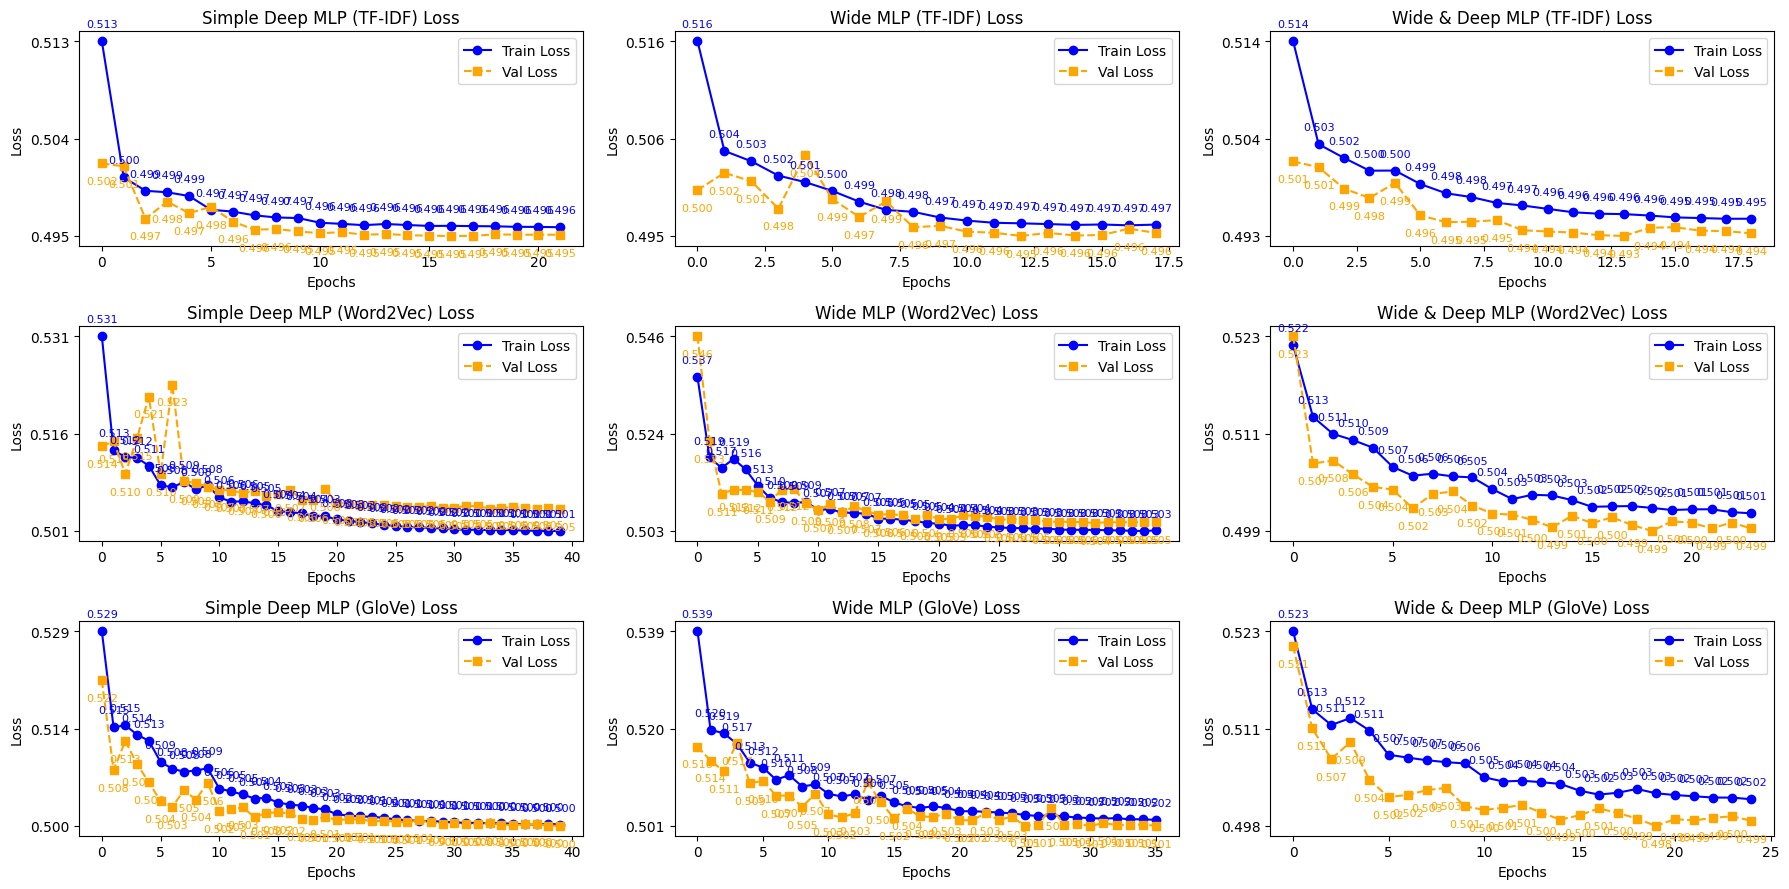

In [ ]:
# Plot Loss Curves
plot_loss_curves(results)


## Performance Metrics Comparison Across Feature Representations (TF-IDF, Word2Vec, GloVe)

This code generates a series of bar plots to compare the performance of various models based on their feature representations: TF-IDF, Word2Vec, and GloVe. The three metrics used for comparison are:

1. **Accuracy**
2. **Weighted F1-score**
3. **PR AUC (Precision-Recall AUC)**

The performance metrics for each model are extracted from the classification report, and the following steps are performed:

#### **1. Extracting Metrics:**
The `extract_metrics` function is used to extract the accuracy and weighted F1-score from the classification report for each model. These metrics are parsed using regular expressions.

#### **2. Grouping Models by Feature Representation:**
Models are grouped based on the feature representation they use. This is done by creating a dictionary `feature_groups` where each key corresponds to a feature type (TF-IDF, Word2Vec, GloVe), and the value is another dictionary containing model names and their corresponding performance data.

#### **3. Plotting the Results:**
- For each feature representation (TF-IDF, Word2Vec, GloVe), the models' performance on the three metrics (accuracy, weighted F1-score, and PR AUC) is extracted.
- A set of bar plots is created for each feature representation. Each plot compares the performance of the models across three datasets: **Train**, **Validation**, and **Test**.

#### **4. Plot Customization:**
- Each bar in the plot represents one of the performance metrics (accuracy, F1-score, or PR AUC) for a specific model.
- The heights of the bars are annotated with their corresponding values for clarity.
- Separate colors are used for each dataset (Train, Validation, and Test) to distinguish between them.
- The x-axis displays the model names, and the y-axis shows the performance scores, with a fixed range of 0 to 1 for all metrics to ensure consistent scaling.

#### **5. Final Visualization:**
- The plots are arranged in a single row with three subplots, one for each metric.
- A combined legend is added below the plots to indicate which bars correspond to Train, Validation, and Test datasets.

These plots provide a visual comparison of how each model performs across different feature representations and datasets. This is helpful in selecting the best-performing model.

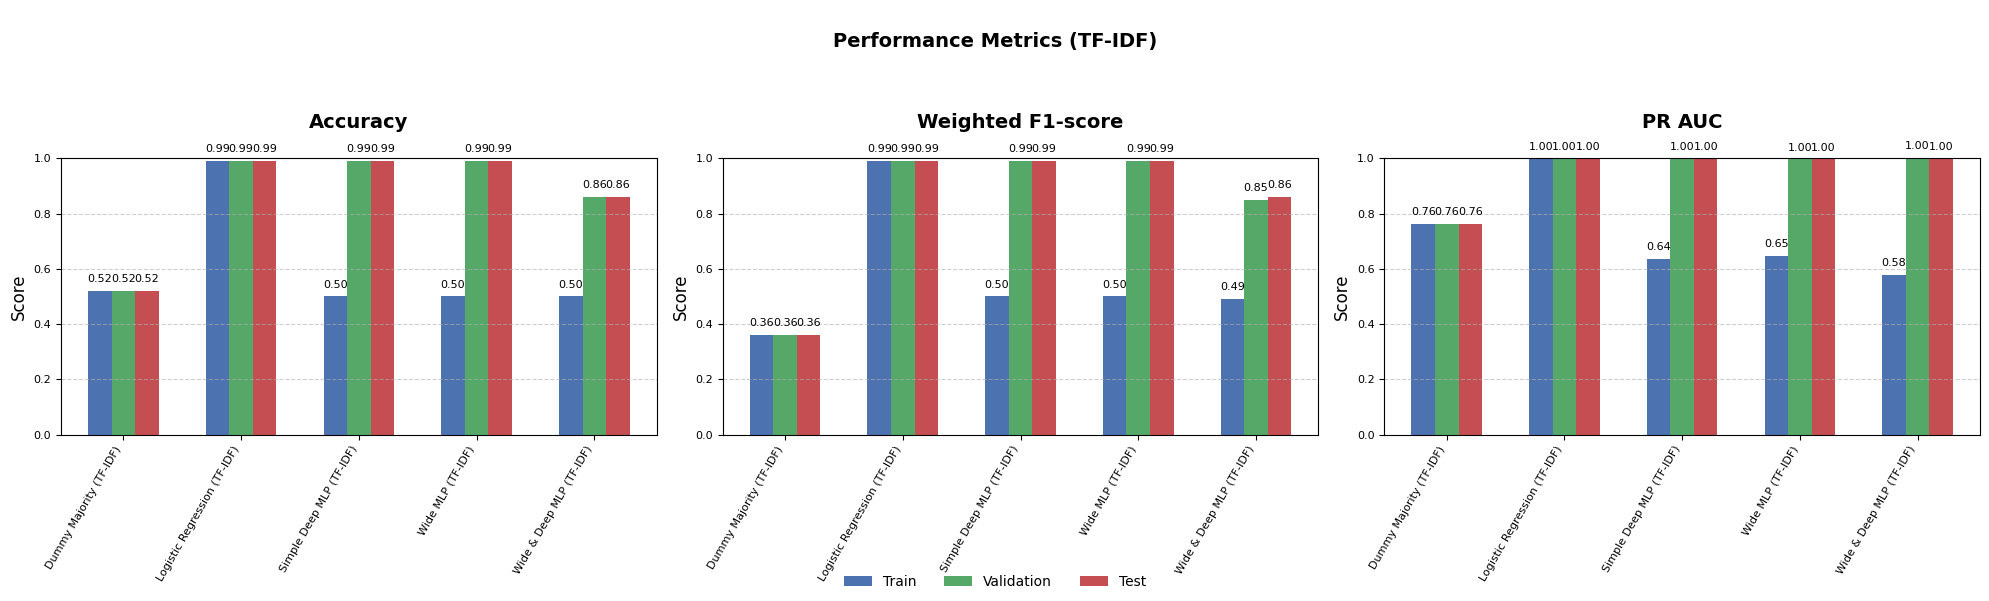

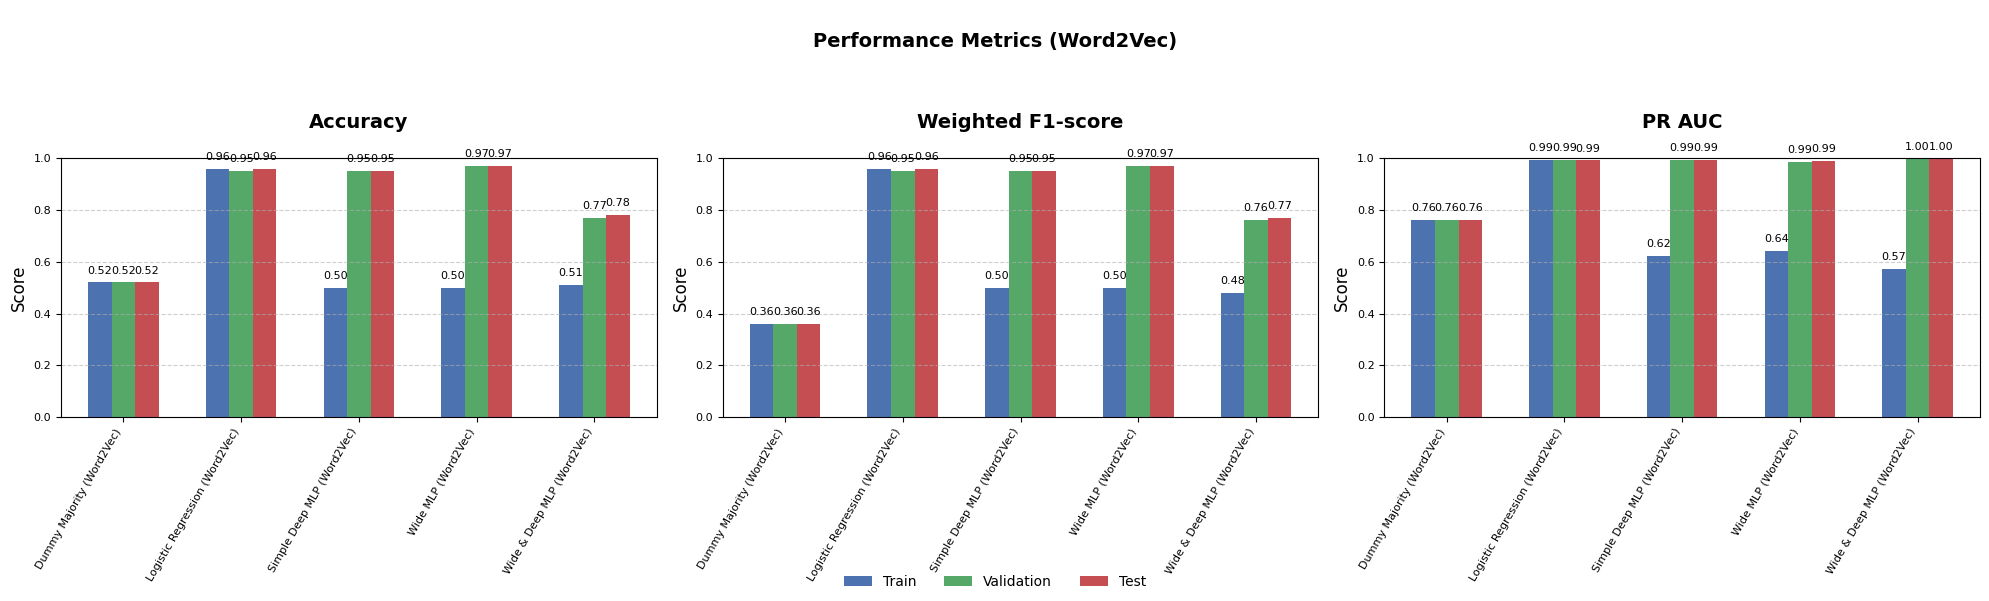

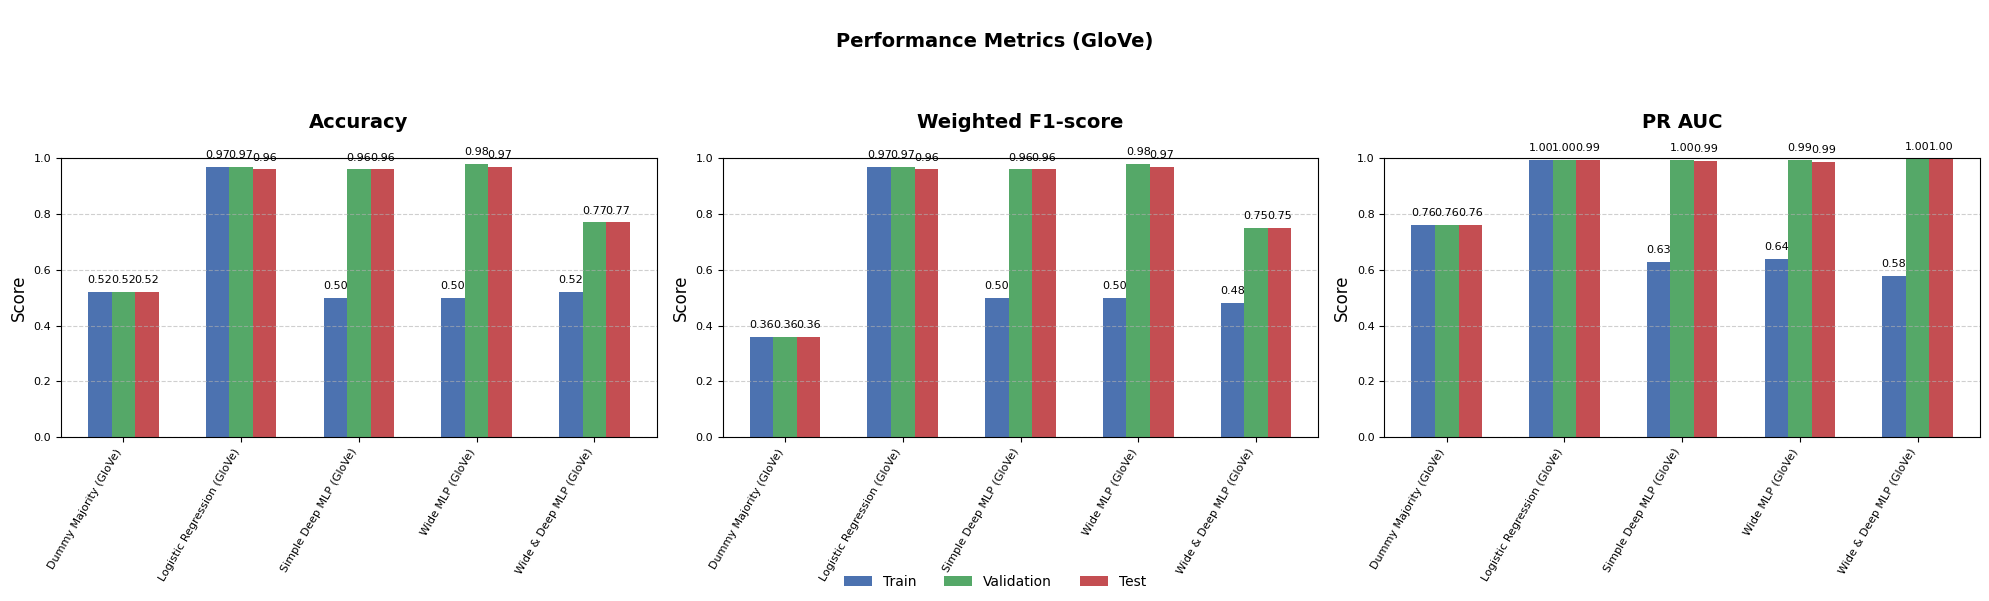

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

# Function to extract accuracy and weighted F1-score from classification report
def extract_metrics(report):
    accuracy_match = re.search(r'accuracy\s+([\d\.]+)', report)
    weighted_f1_match = re.search(r'weighted avg\s+[\d\.]+\s+[\d\.]+\s+([\d\.]+)', report)

    accuracy = float(accuracy_match.group(1)) if accuracy_match else None
    weighted_f1 = float(weighted_f1_match.group(1)) if weighted_f1_match else None

    return accuracy, weighted_f1

# Group models by feature representation (TF-IDF, Word2Vec, GloVe)
feature_groups = {"TF-IDF": {}, "Word2Vec": {}, "GloVe": {}}

for model_name, model_data in results.items():
    if "TF-IDF" in model_name:
        feature_groups["TF-IDF"][model_name] = model_data
    elif "Word2Vec" in model_name or "W2V" in model_name:
        feature_groups["Word2Vec"][model_name] = model_data
    elif "GloVe" in model_name:
        feature_groups["GloVe"][model_name] = model_data

# Use Seaborn color palette
sns_colors = sns.color_palette("deep")  # Seaborn deep palette
colors = [sns_colors[0], sns_colors[2], sns_colors[3]]  # Pick 3 distinct colors

# Iterate over each feature representation
for feature, models_dict in feature_groups.items():
    if not models_dict:  # Skip if no models exist for this feature
        continue

    models = list(models_dict.keys())
    train_acc, val_acc, test_acc = [], [], []
    train_f1, val_f1, test_f1 = [], [], []
    train_pr_auc, val_pr_auc, test_pr_auc = [], [], []

    for model in models:
        metrics = models_dict[model]['metrics']

        # Extract accuracy and F1-score
        acc_train, f1_train = extract_metrics(metrics['train_report'])
        acc_val, f1_val = extract_metrics(metrics['val_report'])
        acc_test, f1_test = extract_metrics(metrics['test_report'])

        # Append values
        train_acc.append(acc_train)
        val_acc.append(acc_val)
        test_acc.append(acc_test)

        train_f1.append(f1_train)
        val_f1.append(f1_val)
        test_f1.append(f1_test)

        # Extract PR AUC
        train_pr_auc.append(metrics['pr_auc']['train_pr_auc'])
        val_pr_auc.append(metrics['pr_auc']['val_pr_auc'])
        test_pr_auc.append(metrics['pr_auc']['test_pr_auc'])

    # Define the metric data for plotting
    metric_data = [
        ("\nAccuracy\n", train_acc, val_acc, test_acc),
        ("\nWeighted F1-score\n", train_f1, val_f1, test_f1),
        ("\nPR AUC\n", train_pr_auc, val_pr_auc, test_pr_auc)
    ]

    # Create figure for this feature representation
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)  # Larger figure size
    fig.suptitle(f"\nPerformance Metrics ({feature})\n", fontsize=14, fontweight="bold")

    x = np.arange(len(models))
    width = 0.2  # Smaller width for spacing

    for i, (title, train_vals, val_vals, test_vals) in enumerate(metric_data):
        ax = axes[i]

        bars1 = ax.bar(x - width, train_vals, width, label="Train", color=colors[0])
        bars2 = ax.bar(x, val_vals, width, label="Validation", color=colors[1])
        bars3 = ax.bar(x + width, test_vals, width, label="Test", color=colors[2])

        # Add value labels on bars
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 5),  # Offset for visibility
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=8)  # Smaller font size for annotations

        # Set labels and formatting
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=60, ha="right", fontsize=10)  # Smaller font size for x labels
        ax.set_title(title, fontsize=14, fontweight="bold")
        ax.set_ylabel("Score", fontsize=12)
        ax.set_ylim(0, 1)  # Ensures consistent scaling
        ax.grid(axis='y', linestyle='--', alpha=0.6)

        # Adjust tick size
        ax.tick_params(axis='both', which='major', labelsize=8)  # Smaller tick marks

    # Add a single legend for the whole row
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=10, frameon=False)

    plt.subplots_adjust(bottom=0.3, top=0.85)
    plt.tight_layout()
    plt.show()


---

# Exercise 10

Develop a part-of-speech (POS) tagger for one of the languages of the Universal
Dependencies treebanks (http://universaldependencies.org/), using an MLP operating on windows of words. Consider only the words, sentences, and
POS tags of the treebanks (not the dependencies or other annotations).

Use Keras/TensorFlow or PyTorch to implement the MLP. You may use any types of word features you prefer, but it
is recommended to use pre-trained word embeddings.

Make sure that you use separate
training, development, and test subsets. Tune the hyper-parameters (e.g., number of hidden
layers, dropout probability) on the development subset. Monitor the performance of the MLP
on the development subset during training to decide how many epochs to use.

Include experimental results of a baseline that tags each word with the most frequent tag it had in the
training data; for words that were not encountered in the training data, the baseline should
return the most frequent tag (over all words) of the training data.

Include in your report:

• Curves showing the loss on training and development data as a function of epochs

• Precision, recall, F1, precision-recall AUC scores, for each class (tag) and classifier,

• Macro-averaged precision, recall, F1, precision-recall AUC scores (averaging the corresponding scores of the previous bullet over the classes), for each classifier, separately for the training, development, and test subsets.

• A short description of the methods and datasets you used, including statistics about
the datasets (e.g., average sentence length, number of training/dev/test sentences and
words, vocabulary size) and a description of the preprocessing steps.

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import requests
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from collections import defaultdict, Counter

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Data Download

In [ ]:
# URLs for the train, dev, and test data
urls = {
    "train": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu",
    "dev": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu",
    "test": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu"
}

# Function to download data from URLs
def download_data(url, filename):
    if os.path.exists(filename):
        print(f"{filename} already exists, skipping download.")
        return

    try:
        print(f"Downloading {filename}...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(response.text)
        print(f"Downloaded {filename}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {filename}: {e}")

# Download train, dev, and test data
download_data(urls['train'], 'en_ewt-ud-train.conllu')
download_data(urls['dev'], 'en_ewt-ud-dev.conllu')
download_data(urls['test'], 'en_ewt-ud-test.conllu')

en_ewt-ud-train.conllu already exists, skipping download.
en_ewt-ud-dev.conllu already exists, skipping download.
en_ewt-ud-test.conllu already exists, skipping download.


## Data Parsing and Preprocessing

In [ ]:
def parse_conllu_file(filename):
    """
    Parse a .conllu file to extract words and their POS tags.
    Returns a list of sentences, where each sentence is a list of tuples (word, pos_tag).
    """
    sentences = []
    sentence = []

    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            # Skip empty lines and comments
            if line.strip() == "" or line.startswith("#"):
                continue

            # Split each line into columns (word, pos_tag, etc.)
            columns = line.strip().split("\t")
            word = columns[1]
            pos_tag = columns[3]

            sentence.append((word, pos_tag))

            # Check if we reached the end of a sentence (a line with only space or empty)
            if len(columns) == 1:
                if sentence:
                    sentences.append(sentence)
                sentence = []

    # In case the last sentence doesn't have an empty line at the end
    if sentence:
        sentences.append(sentence)

    return sentences


train_data = parse_conllu_file('en_ewt-ud-train.conllu')
dev_data = parse_conllu_file('en_ewt-ud-dev.conllu')
test_data = parse_conllu_file('en_ewt-ud-test.conllu')

print(train_data[:1])  # Print first sentence for inspection


[[('Al', 'PROPN'), ('-', 'PUNCT'), ('Zaman', 'PROPN'), (':', 'PUNCT'), ('American', 'ADJ'), ('forces', 'NOUN'), ('killed', 'VERB'), ('Shaikh', 'PROPN'), ('Abdullah', 'PROPN'), ('al', 'PROPN'), ('-', 'PUNCT'), ('Ani', 'PROPN'), (',', 'PUNCT'), ('the', 'DET'), ('preacher', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('mosque', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('town', 'NOUN'), ('of', 'ADP'), ('Qaim', 'PROPN'), (',', 'PUNCT'), ('near', 'ADP'), ('the', 'DET'), ('Syrian', 'ADJ'), ('border', 'NOUN'), ('.', 'PUNCT'), ('[', 'PUNCT'), ('This', 'DET'), ('killing', 'NOUN'), ('of', 'ADP'), ('a', 'DET'), ('respected', 'ADJ'), ('cleric', 'NOUN'), ('will', 'AUX'), ('be', 'AUX'), ('causing', 'VERB'), ('us', 'PRON'), ('trouble', 'NOUN'), ('for', 'ADP'), ('years', 'NOUN'), ('to', 'PART'), ('come', 'VERB'), ('.', 'PUNCT'), (']', 'PUNCT'), ('DPA', 'PROPN'), (':', 'PUNCT'), ('Iraqi', 'ADJ'), ('authorities', 'NOUN'), ('announced', 'VERB'), ('that', 'SCONJ'), ('they', 'PRON'), ('had', 'AUX'), ('busted', '

In [ ]:
def display_words_per_tag(data):
    """
    Display 5 words for each POS tag.
    """
    tag_to_words = {tag: [] for tag in set(tag for sentence in data for _, tag in sentence)}

    # Collect words for each POS tag
    for sentence in data:
        for word, tag in sentence:
            tag_to_words[tag].append(word)

    # Display 5 random words for each tag
    for tag, words in tag_to_words.items():
        print(f"\n{tag}:")
        sample_words = random.sample(words, min(5, len(words)))  # Get 5 words or less if not enough words
        for word in sample_words:
            print(f"  - {word}")

# Display words for each tag in the training dataset
print("Sample Words for Each Tag:")
display_words_per_tag(train_data)


Sample Words for Each Tag:
Sample words for each POS tag:

AUX:
  - 'm
  - would
  - be
  - was
  - can

PROPN:
  - Gas
  - SAP
  - Maryam
  - Road
  - Qaeda

SCONJ:
  - than
  - of
  - while
  - since
  - that

CCONJ:
  - and
  - and
  - and
  - and
  - or

SYM:
  - /
  - %
  - :)
  - %
  - $

PUNCT:
  - ?
  - .
  - .
  - ,
  - .

NUM:
  - 24
  - 2.7
  - 2
  - 4
  - four

X:
  - fall
  - -
  - day
  - forma
  - Pricing

PRON:
  - I
  - your
  - him
  - My
  - me

ADV:
  - there
  - out
  - also
  - right
  - about

ADJ:
  - related
  - definitive
  - natural
  - worst
  - easy

PART:
  - s
  - to
  - to
  - not
  - not

_:
  - doesn't
  - it's
  - Don't
  - Its
  - I've

VERB:
  - let
  - accumulating
  - are
  - turn
  - thought

DET:
  - the
  - any
  - the
  - the
  - The

INTJ:
  - Hello
  - please
  - hi
  - Please
  - Please

ADP:
  - overt
  - out
  - in
  - From
  - of

NOUN:
  - Climate
  - culture
  - storage
  - equality
  - email


In [ ]:
def extract_context_windows(sentences, word2vec_model, window_size=3):
    data = []
    for sentence in sentences:
        # Loop over each word in the sentence, using it as the target word
        for i, (word, pos_tag) in enumerate(sentence):
            # Create a context window of size 3
            context = []
            for j in range(-window_size, window_size + 1):
                if i + j >= 0 and i + j < len(sentence) and j != 0:
                    context.append(sentence[i + j][0])  # Add context word (excluding the target word)

            # Convert the context words to embeddings (Word2Vec)
            context_embeddings = []
            for context_word in context:
                if context_word in word2vec_model:
                    context_embeddings.append(word2vec_model[context_word])
                else:
                    context_embeddings.append(np.zeros(word2vec_model.vector_size))  # For unknown words

            # Aggregate context embeddings into a single vector (average of all context word embeddings)
            context_vector = np.mean(context_embeddings, axis=0)  # Averaging the context words' embeddings
            target_word_embedding = word2vec_model[word] if word in word2vec_model else np.zeros(word2vec_model.vector_size)

            # Combine the context and target word embeddings into one feature vector
            feature_vector = np.concatenate([context_vector, target_word_embedding])

            # Append the feature vector along with the corresponding POS tag
            data.append((feature_vector, pos_tag))

    return data

# Load the pre-trained Word2Vec model (using the example from gensim)
import gensim.downloader as api
word2vec = api.load("word2vec-google-news-300")  # 300-dimensional Word2Vec embeddings

# Extract training, dev, and test data
train_features = extract_context_windows(train_data, word2vec)
dev_features = extract_context_windows(dev_data, word2vec)
test_features = extract_context_windows(test_data, word2vec)


In [ ]:
# Prepare the data
def prepare_data(features):
    # Extract feature vectors and labels
    X = [f[0] for f in features]
    y = [f[1] for f in features]

    # Convert feature vectors into tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)

    # Encode POS tags as integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_tensor = torch.tensor(y_encoded, dtype=torch.long)

    return TensorDataset(X_tensor, y_tensor)

# Prepare the datasets for training, dev, and test
train_dataset = prepare_data(train_features)
dev_dataset = prepare_data(dev_features)
test_dataset = prepare_data(test_features)

# Create DataLoader for batching
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## MLPs Architecture, Training and Evaluation

In [ ]:
class ShallowPOS_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(ShallowPOS_MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Single hidden layer
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))  # First layer with ReLU activation
        x = self.dropout(x)  # Apply dropout for regularization
        x = self.fc2(x)  # Output layer
        return x


In [ ]:
class DeepPOS_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(DeepPOS_MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))  # Second hidden layer with ReLU activation
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:
class VeryDeepPOS_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(VeryDeepPOS_MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))  # Third hidden layer with ReLU activation
        x = self.dropout(x)
        x = self.fc4(x)
        return x


### Why We Picked These Specific Architectures

We chose three MLP architectures (Shallow, Deep, and Very Deep) to explore different levels of model complexity and expressiveness:

1. **Shallow MLP (1 hidden layer)**:
   - **Simplicity**: Serves as a baseline model, ideal for smaller datasets or simpler tasks.
   - **Efficiency**: Computationally inexpensive and faster to train.
   - **Lower risk of overfitting**: Suitable for less complex tasks.

2. **Deep MLP (2 hidden layers)**:
   - **Increased expressiveness**: Can capture more complex relationships in data.
   - **Better performance**: Ideal for these datasets where complexity increases but overfitting needs to be avoided.
   - **Balanced complexity**: More capable than shallow models while still being manageable.

3. **Very Deep MLP (3 hidden layers)**:
   - **High capacity**: Captures intricate and abstract features, beneficial for large or complex datasets.
   - **Better pattern recognition**: Useful for tasks where deep hierarchies and complex relationships are needed.
   


### Adding Other Types of Layers

1. **Convolutional Layers**:
   - **Reason**: To capture local patterns (e.g., in text or time-series data).
   - **Benefit**: Helps identify local dependencies like neighboring word relationships in POS tagging.

2. **Recurrent Layers (LSTM/GRU)**:
   - **Reason**: Captures long-term dependencies in sequential data like POS tagging.
   - **Benefit**: Improves context-based predictions for tasks with temporal or sequential patterns.

3. **Attention Mechanisms**:
   - **Reason**: Focuses on important parts of the input for better predictions.
   - **Benefit**: Improves performance by emphasizing relevant parts of the data.

4. **Embedding Layers**:
   - **Reason**: Converts words into dense vector representations for better semantic understanding.
   - **Benefit**: Enhances model generalization and improves performance on NLP tasks.

### Why We Didn't Add More Layers

The decision to keep the models simple with only fully connected (dense) layers was based on several key factors:

1. **Model Complexity and Overfitting**:
   - Adding too many layers can lead to overfitting, especially on smaller or simpler datasets. The more layers you introduce, the more parameters the model has, which increases the risk of memorizing the training data rather than learning generalizable patterns.
   - By limiting the layers, we maintain a balance between model complexity and generalization which is particularly important for avoiding overfitting.

2. **Computational Efficiency**:
   - The goal was to ensure efficient training and inference. Adding layers like convolutional or recurrent layers increases both the time and memory complexity of the model.
   
3. **Simplicity and Interpretability**:
   - Shallow architectures, like the one used here, are often easier to interpret and debug. By sticking to a basic MLP structure, we reduce the complexity of the model and make it easier to track how it’s learning.
   
4. **Suitability for Task**:
   - For POS tagging, which can be performed well with dense, fully connected layers, we felt that additional layers such as convolutional, recurrent, or attention layers would not offer a significant improvement, especially in comparison to the added complexity and computational cost. These simpler MLP architectures are often sufficient for such tasks.
   
5. **Starting Point for Experimentation**:
   - The chosen architectures (Shallow, Deep, Very Deep) provide a clear and structured approach to explore model depth and performance. Introducing more types of layers could complicate early experimentation, and we wanted to first evaluate how increasing depth within fully connected layers impacts the model's performance before moving on to more complex architectures.

In conclusion, keeping the architecture focused on fully connected layers strikes a balance between performance and simplicity, avoiding unnecessary complexity for the given task and dataset size.


In [ ]:
# Get the unique POS tags from the training data
pos_tags = list(set([tag for _, tag in train_features]))
pos_tags.sort()  # Sort for a consistent order

# Create a dictionary that maps index to POS tag
tag_to_idx = {pos_tags[i]: i for i in range(len(pos_tags))}
idx_to_tag = {i: pos_tags[i] for i in range(len(pos_tags))}


In [ ]:
def train_and_evaluate(model_class, input_dim, hidden_dim, output_dim, num_epochs=20):
    # Initialize the model
    model = model_class(input_dim, hidden_dim, output_dim, dropout=0.5)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store loss during training
    train_losses = []
    dev_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients. In PyTorch, gradients are accumulated by default during backpropagation. If you don’t zero out the gradients, they will be summed up across multiple backward passes. This can lead to incorrect gradient updates.
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimize

            total_train_loss += loss.item()

        train_losses.append(total_train_loss)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        total_dev_loss = 0
        with torch.no_grad(): # During inference (model evaluation or testing), you don’t need gradients because you’re not performing backpropagation. Disabling gradient tracking saves memory and computation.
            for inputs, labels in dev_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_dev_loss += loss.item()

        dev_losses.append(total_dev_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_train_loss}, Dev Loss: {total_dev_loss}")

    # Plotting training and validation loss curves
    plt.figure(figsize=(10, 6))
    # plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss",)
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", color='#00008B')
    plt.plot(range(1, num_epochs+1), dev_losses, label="Dev Loss", linestyle='--', color='#00008B')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Evaluate on the test set
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []  # To store the predicted probabilities

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
            y_prob.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Get probabilities

    # Convert numeric labels to POS tags using idx_to_tag
    y_true_tags = [idx_to_tag[idx] for idx in y_true]
    y_pred_tags = [idx_to_tag[idx] for idx in y_pred]

    # Classification report with tags instead of numeric class labels
    print(f"Classification Report for {model_class.__name__}:")
    print(classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, zero_division=0))

    # Calculate AUC scores for each class
    auc_scores = {}
    for i, tag in enumerate(pos_tags):
        # One-hot encode the true labels for the current tag
        true_binary = [1 if label == i else 0 for label in y_true]
        pred_prob = [prob[i] for prob in y_prob]  # Probabilities for the current tag

        auc_score = roc_auc_score(true_binary, pred_prob)
        auc_scores[tag] = auc_score

    # Print AUC scores for each class
    print("\nAUC Scores for Each Class:")
    for tag, auc in auc_scores.items():
        print(f"{tag}: {auc:.4f}")

    # Calculate Macro-Averaged Precision, Recall, F1, and Precision-Recall AUC
    # Precision, recall, and F1
    report = classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, output_dict=True, zero_division=0)
    precision_macro = report["macro avg"]["precision"]
    recall_macro = report["macro avg"]["recall"]
    f1_macro = report["macro avg"]["f1-score"]

    # Precision-Recall AUC (macro-average)
    precision_recall_auc_macro = np.mean([roc_auc_score([1 if label == i else 0 for label in y_true],
                                                       [prob[i] for prob in y_prob]) for i in range(len(pos_tags))])

    # Print Macro-Averaged Metrics
    print(f"\nMacro-Averaged Precision: {precision_macro}")
    print(f"Macro-Averaged Recall: {recall_macro}")
    print(f"Macro-Averaged F1: {f1_macro}")
    print(f"Macro-Averaged Precision-Recall AUC: {precision_recall_auc_macro}")

    return model


Training Shallow MLP:
Epoch 1/20, Train Loss: 2487.628724694252, Dev Loss: 239.0158531665802
Epoch 2/20, Train Loss: 1880.5576054304838, Dev Loss: 224.8769073188305
Epoch 3/20, Train Loss: 1772.451532870531, Dev Loss: 221.4169827401638
Epoch 4/20, Train Loss: 1715.84065105021, Dev Loss: 217.5296540260315
Epoch 5/20, Train Loss: 1676.634464636445, Dev Loss: 215.8184494227171
Epoch 6/20, Train Loss: 1641.2918900251389, Dev Loss: 213.61387968063354
Epoch 7/20, Train Loss: 1616.4067249149084, Dev Loss: 214.1634572595358
Epoch 8/20, Train Loss: 1595.938673466444, Dev Loss: 214.38553020358086
Epoch 9/20, Train Loss: 1578.6978471428156, Dev Loss: 213.17859655618668
Epoch 10/20, Train Loss: 1562.2563051879406, Dev Loss: 214.02639035880566
Epoch 11/20, Train Loss: 1545.149732619524, Dev Loss: 215.34580318629742
Epoch 12/20, Train Loss: 1537.7930569946766, Dev Loss: 213.6443422138691
Epoch 13/20, Train Loss: 1522.7121153622866, Dev Loss: 214.53271222114563
Epoch 14/20, Train Loss: 1519.260555833

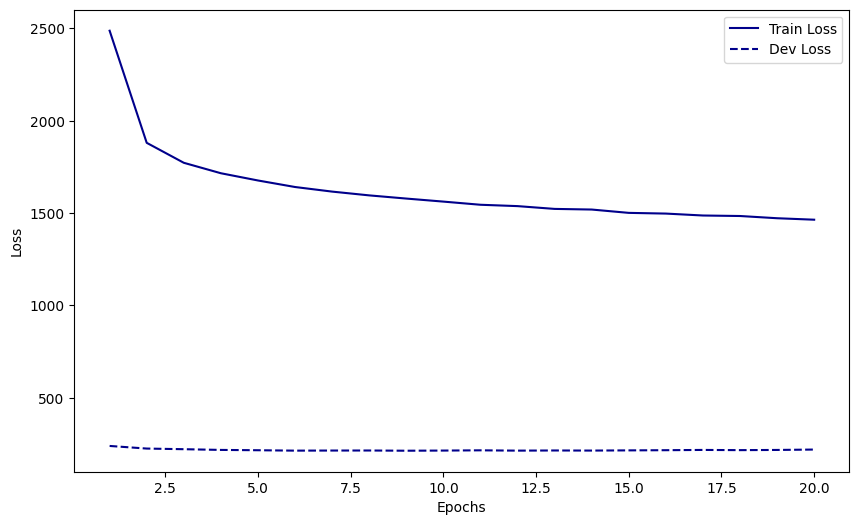

Classification Report for ShallowPOS_MLP:
              precision    recall  f1-score   support

         ADJ       0.92      0.88      0.90      1794
         ADP       0.82      0.76      0.79      2030
         ADV       0.91      0.86      0.88      1183
         AUX       0.94      0.97      0.95      1543
       CCONJ       0.75      0.34      0.46       736
         DET       0.88      0.78      0.83      1896
        INTJ       0.96      0.74      0.83       121
        NOUN       0.90      0.89      0.90      4123
         NUM       0.63      0.51      0.57       542
        PART       0.67      0.61      0.64       649
        PRON       0.97      0.96      0.97      2166
       PROPN       0.88      0.81      0.84      2076
       PUNCT       0.59      0.90      0.71      3096
       SCONJ       0.77      0.65      0.71       384
         SYM       0.94      0.61      0.74       109
        VERB       0.93      0.89      0.91      2606
           X       0.00      0.00      

In [ ]:
print("Training Shallow MLP:")
shallow_model = train_and_evaluate(ShallowPOS_MLP, input_dim=2*word2vec.vector_size, hidden_dim=128, output_dim=len(set([f[1] for f in train_features])), num_epochs=20)


Training Somewhat Deep MLP:
Epoch 1/20, Train Loss: 2368.972687959671, Dev Loss: 236.01379914581776
Epoch 2/20, Train Loss: 1810.2979687601328, Dev Loss: 226.61035127937794
Epoch 3/20, Train Loss: 1673.139632500708, Dev Loss: 218.3626715540886
Epoch 4/20, Train Loss: 1587.1272729933262, Dev Loss: 213.34799091517925
Epoch 5/20, Train Loss: 1521.3918149471283, Dev Loss: 213.78560818731785
Epoch 6/20, Train Loss: 1461.3324899822474, Dev Loss: 214.49091900885105
Epoch 7/20, Train Loss: 1417.3827497288585, Dev Loss: 217.49580043554306
Epoch 8/20, Train Loss: 1366.458241418004, Dev Loss: 220.09760899841785
Epoch 9/20, Train Loss: 1334.866234742105, Dev Loss: 225.4418142735958
Epoch 10/20, Train Loss: 1302.147398263216, Dev Loss: 227.0092499256134
Epoch 11/20, Train Loss: 1267.4159463644028, Dev Loss: 232.31591953337193
Epoch 12/20, Train Loss: 1241.8476319536567, Dev Loss: 237.80643305182457
Epoch 13/20, Train Loss: 1220.5980688780546, Dev Loss: 236.52202494442463
Epoch 14/20, Train Loss: 11

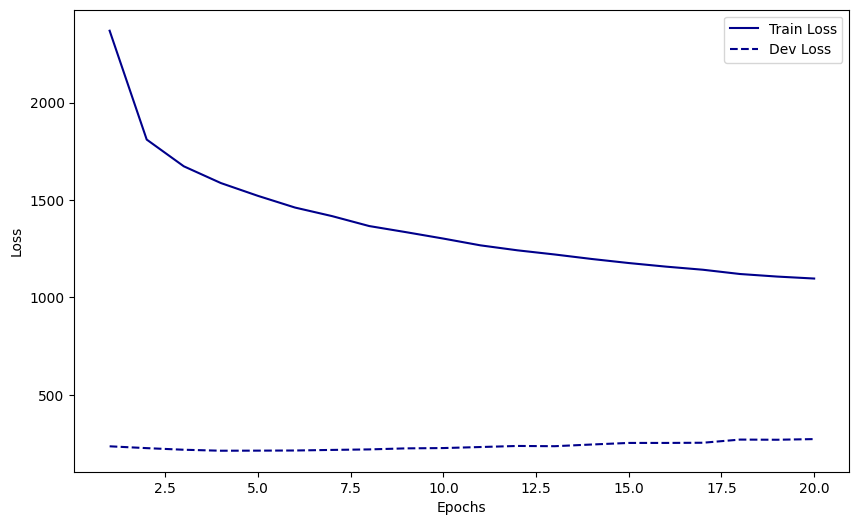

Classification Report for DeepPOS_MLP:
              precision    recall  f1-score   support

         ADJ       0.91      0.87      0.89      1794
         ADP       0.79      0.77      0.78      2030
         ADV       0.91      0.87      0.89      1183
         AUX       0.96      0.96      0.96      1543
       CCONJ       0.70      0.34      0.45       736
         DET       0.87      0.77      0.82      1896
        INTJ       0.93      0.68      0.78       121
        NOUN       0.89      0.89      0.89      4123
         NUM       0.56      0.56      0.56       542
        PART       0.65      0.60      0.62       649
        PRON       0.97      0.97      0.97      2166
       PROPN       0.89      0.79      0.84      2076
       PUNCT       0.60      0.86      0.70      3096
       SCONJ       0.80      0.65      0.72       384
         SYM       0.93      0.60      0.73       109
        VERB       0.92      0.91      0.91      2606
           X       0.00      0.00      0.0

In [ ]:
print("Training Somewhat Deep MLP:")
deep_model = train_and_evaluate(DeepPOS_MLP, input_dim=2*word2vec.vector_size, hidden_dim=128, output_dim=len(set([f[1] for f in train_features])), num_epochs=20)


Training Deep MLP:
Epoch 1/20, Train Loss: 2376.2586891055107, Dev Loss: 235.04231701791286
Epoch 2/20, Train Loss: 1786.6116228997707, Dev Loss: 225.92248821258545
Epoch 3/20, Train Loss: 1646.5832473039627, Dev Loss: 222.3802939504385
Epoch 4/20, Train Loss: 1550.7370206415653, Dev Loss: 217.8673692792654
Epoch 5/20, Train Loss: 1466.8394483178854, Dev Loss: 221.42730598151684
Epoch 6/20, Train Loss: 1407.4774709194899, Dev Loss: 217.03836742043495
Epoch 7/20, Train Loss: 1341.0882495641708, Dev Loss: 228.16171610355377
Epoch 8/20, Train Loss: 1294.6896402463317, Dev Loss: 228.74935557693243
Epoch 9/20, Train Loss: 1248.3857691660523, Dev Loss: 236.5930026769638
Epoch 10/20, Train Loss: 1207.998226299882, Dev Loss: 243.35564750432968
Epoch 11/20, Train Loss: 1174.933920301497, Dev Loss: 247.9553687274456
Epoch 12/20, Train Loss: 1142.4845060780644, Dev Loss: 264.8668832182884
Epoch 13/20, Train Loss: 1110.2738841623068, Dev Loss: 274.02378419041634
Epoch 14/20, Train Loss: 1085.94729

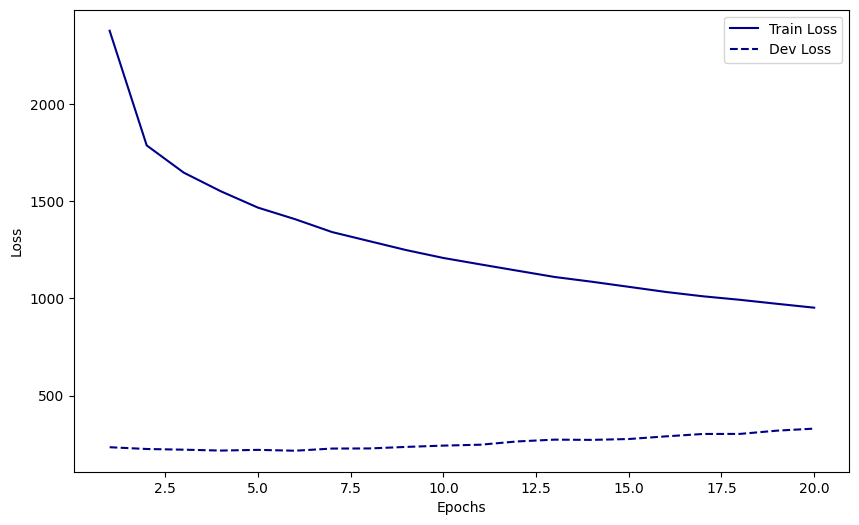

Classification Report for VeryDeepPOS_MLP:
              precision    recall  f1-score   support

         ADJ       0.91      0.87      0.89      1794
         ADP       0.73      0.80      0.76      2030
         ADV       0.90      0.84      0.87      1183
         AUX       0.95      0.96      0.95      1543
       CCONJ       0.72      0.30      0.42       736
         DET       0.76      0.84      0.80      1896
        INTJ       0.92      0.75      0.83       121
        NOUN       0.88      0.89      0.89      4123
         NUM       0.61      0.46      0.52       542
        PART       0.62      0.65      0.63       649
        PRON       0.97      0.96      0.97      2166
       PROPN       0.88      0.78      0.82      2076
       PUNCT       0.62      0.78      0.69      3096
       SCONJ       0.82      0.62      0.71       384
         SYM       0.93      0.61      0.74       109
        VERB       0.92      0.90      0.91      2606
           X       0.06      0.02     

In [ ]:
print("Training Deep MLP:")
very_deep_model = train_and_evaluate(VeryDeepPOS_MLP, input_dim=2*word2vec.vector_size, hidden_dim=128, output_dim=len(set([f[1] for f in train_features])), num_epochs=20)


## Baseline Tagger(s)

In [ ]:
class BaselineTagger:
    def __init__(self, train_data):
        """
        Initializes the baseline tagger. It trains on the given training data
        by counting the most frequent tag for each word.
        """
        self.word_to_tag = defaultdict(lambda: None)  # Default None for unseen words
        self.most_frequent_tag = None
        self.train(train_data)

    def train(self, train_data):
        """
        Trains the baseline tagger by recording the most frequent tag for each word.
        """
        word_tag_counts = defaultdict(lambda: defaultdict(int))  # Count tags per word

        # Count occurrences of each word-tag pair in the training data
        for sentence in train_data:
            for word, tag in sentence:
                word_tag_counts[word][tag] += 1

        # For each word, find the most frequent tag
        for word, tag_counts in word_tag_counts.items():
            self.word_to_tag[word] = max(tag_counts, key=tag_counts.get)

        # Find the most frequent tag overall in the training data (for unseen words)
        tag_counts = defaultdict(int)
        for sentence in train_data:
            for _, tag in sentence:
                tag_counts[tag] += 1

        # Set the most frequent tag to handle unseen words
        self.most_frequent_tag = max(tag_counts, key=tag_counts.get)

    def predict(self, sentence):
        """
        Predicts the tags for the given sentence using the baseline strategy.
        For each word, it returns the most frequent tag it has in the training data,
        or the most frequent tag overall if the word is unseen.
        """
        return [self.word_to_tag.get(word, self.most_frequent_tag) for word, _ in sentence]

    def evaluate(self, test_data):
        """
        Evaluates the baseline tagger on the given test data and prints precision, recall, F1,
        and AUC scores.
        """
        y_true = []
        y_pred = []
        y_prob = []

        for sentence in test_data:
            true_tags = [tag for _, tag in sentence]
            predicted_tags = self.predict(sentence)

            y_true.extend(true_tags)
            y_pred.extend(predicted_tags)

        # Convert numeric labels to POS tags using idx_to_tag
        y_true_tags = [tag_to_idx[idx] for idx in y_true]
        y_pred_tags = [tag_to_idx[idx] for idx in y_pred]

        # Classification report with tags instead of numeric class labels
        print(f"Baseline Tagger Classification Report:")
        print(classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, zero_division=0))

        # Calculate AUC scores for each class
        auc_scores = {}
        for i, tag in enumerate(pos_tags):
            # One-hot encode the true labels for the current tag
            true_binary = [1 if label == i else 0 for label in y_true_tags]
            pred_binary = [1 if label == i else 0 for label in y_pred_tags]
            auc_score = roc_auc_score(true_binary, pred_binary)
            auc_scores[tag] = auc_score

        # Print AUC scores for each class
        print("\nAUC Scores for Each Class:")
        for tag, auc in auc_scores.items():
            print(f"{tag}: {auc:.4f}")

        # Calculate Macro-Averaged Precision, Recall, F1, and Precision-Recall AUC
        report = classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, output_dict=True, zero_division=0)
        precision_macro = report["macro avg"]["precision"]
        recall_macro = report["macro avg"]["recall"]
        f1_macro = report["macro avg"]["f1-score"]

        # Precision-Recall AUC (macro-average)
        precision_recall_auc_macro = np.mean([roc_auc_score([1 if label == i else 0 for label in y_true_tags],
                                                           [1 if label == i else 0 for label in y_pred_tags]) for i in range(len(pos_tags))])

        # Print Macro-Averaged Metrics
        print(f"\nMacro-Averaged Precision: {precision_macro:.4f}")
        print(f"Macro-Averaged Recall: {recall_macro:.4f}")
        print(f"Macro-Averaged F1: {f1_macro:.4f}")
        print(f"Macro-Averaged Precision-Recall AUC: {precision_recall_auc_macro:.4f}")


In [ ]:
# Train the baseline tagger
baseline_tagger = BaselineTagger(train_data)

# Evaluate on the test set
baseline_tagger.evaluate(test_data)


Baseline Tagger Classification Report:
              precision    recall  f1-score   support

         ADJ       0.91      0.83      0.87      1794
         ADP       0.87      0.88      0.88      2030
         ADV       0.94      0.79      0.86      1183
         AUX       0.93      0.89      0.91      1543
       CCONJ       0.99      1.00      0.99       736
         DET       0.96      0.97      0.96      1896
        INTJ       0.97      0.69      0.80       121
        NOUN       0.67      0.93      0.78      4123
         NUM       0.91      0.61      0.73       542
        PART       0.69      0.99      0.81       649
        PRON       0.96      0.93      0.95      2166
       PROPN       0.91      0.51      0.66      2076
       PUNCT       0.99      0.99      0.99      3096
       SCONJ       0.62      0.60      0.61       384
         SYM       0.81      0.83      0.82       109
        VERB       0.89      0.82      0.85      2606
           X       1.00      0.00      0.0

In [ ]:
class DummyTagger:
    def __init__(self, train_data):
        """
        Initializes the dummy tagger. It trains on the given training data
        by finding the most frequent tag overall in the training data.
        """
        self.most_frequent_tag = None
        self.train(train_data)

    def train(self, train_data):
        """
        Trains the dummy tagger by finding the most frequent tag in the training data.
        """
        tag_counts = defaultdict(int)

        # Count occurrences of each tag in the training data
        for sentence in train_data:
            for _, tag in sentence:
                tag_counts[tag] += 1

        # Find the most frequent tag in the training data
        self.most_frequent_tag = max(tag_counts, key=tag_counts.get)

    def predict(self, sentence):
        """
        Predicts the tag for every word in the sentence using the dummy strategy.
        Every word gets the most frequent tag found during training.
        """
        return [self.most_frequent_tag for _ in sentence]

    def evaluate(self, test_data):
        """
        Evaluates the dummy tagger on the given test data and prints precision, recall, F1,
        and AUC scores.
        """
        y_true = []
        y_pred = []
        y_prob = []  # Dummy tagger does not return probabilities, so we'll skip this.

        for sentence in test_data:
            true_tags = [tag for _, tag in sentence]
            predicted_tags = self.predict(sentence)

            y_true.extend(true_tags)
            y_pred.extend(predicted_tags)

        # Convert numeric labels to POS tags using idx_to_tag
        y_true_tags = [tag_to_idx[idx] for idx in y_true]
        y_pred_tags = [tag_to_idx[idx] for idx in y_pred]

        # Classification report with tags instead of numeric class labels
        print(f"Dummy Tagger Classification Report:")
        print(classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, zero_division=0))

        # Calculate AUC scores for each class
        auc_scores = {}
        for i, tag in enumerate(pos_tags):
            # One-hot encode the true labels for the current tag
            true_binary = [1 if label == i else 0 for label in y_true_tags]
            pred_binary = [1 if label == i else 0 for label in y_pred_tags]

            auc_score = roc_auc_score(true_binary, pred_binary)
            auc_scores[tag] = auc_score

        # Print AUC scores for each class
        print("\nAUC Scores for Each Class:")
        for tag, auc in auc_scores.items():
            print(f"{tag}: {auc:.4f}")

        # Calculate Macro-Averaged Precision, Recall, F1, and Precision-Recall AUC
        report = classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, output_dict=True, zero_division=0)
        precision_macro = report["macro avg"]["precision"]
        recall_macro = report["macro avg"]["recall"]
        f1_macro = report["macro avg"]["f1-score"]

        # Precision-Recall AUC (macro-average)
        precision_recall_auc_macro = np.mean([roc_auc_score([1 if label == i else 0 for label in y_true_tags],
                                                           [1 if label == i else 0 for label in y_pred_tags]) for i in range(len(pos_tags))])

        # Print Macro-Averaged Metrics
        print(f"\nMacro-Averaged Precision: {precision_macro:.4f}")
        print(f"Macro-Averaged Recall: {recall_macro:.4f}")
        print(f"Macro-Averaged F1: {f1_macro:.4f}")
        print(f"Macro-Averaged Precision-Recall AUC: {precision_recall_auc_macro:.4f}")


In [ ]:
# Train the dummy tagger
dummy_tagger = DummyTagger(train_data)

# Evaluate on the test set
dummy_tagger.evaluate(test_data)


Dummy Tagger Classification Report:
              precision    recall  f1-score   support

         ADJ       0.00      0.00      0.00      1794
         ADP       0.00      0.00      0.00      2030
         ADV       0.00      0.00      0.00      1183
         AUX       0.00      0.00      0.00      1543
       CCONJ       0.00      0.00      0.00       736
         DET       0.00      0.00      0.00      1896
        INTJ       0.00      0.00      0.00       121
        NOUN       0.16      1.00      0.28      4123
         NUM       0.00      0.00      0.00       542
        PART       0.00      0.00      0.00       649
        PRON       0.00      0.00      0.00      2166
       PROPN       0.00      0.00      0.00      2076
       PUNCT       0.00      0.00      0.00      3096
       SCONJ       0.00      0.00      0.00       384
         SYM       0.00      0.00      0.00       109
        VERB       0.00      0.00      0.00      2606
           X       0.00      0.00      0.00  

## Differences between the **Baseline Tagger** and the **Dummy Tagger**:

### 1. **Training Strategy**:
   - **Baseline Tagger**:
     - The **Baseline Tagger** learns the most frequent tag for each **word** in the training data. For unseen words, it assigns the **most frequent tag** overall in the training data.
     - It essentially builds a dictionary `word_to_tag` where each word maps to its most frequent tag.
  
   - **Dummy Tagger**:
     - The **Dummy Tagger**, on the other hand, does not consider individual words. It assigns the **most frequent tag** across all words in the training data to every word in a sentence, regardless of the word itself.
     - It essentially calculates the most frequent tag in the entire training dataset and uses that tag for every word during prediction.

### 2. **Tagging Logic**:
   - **Baseline Tagger**:
     - For each word in the input sentence, it checks if the word has been encountered in the training data. If yes, it assigns the most frequent tag for that word. If not, it assigns the most frequent tag overall.
     - This approach uses word-specific tagging.
  
   - **Dummy Tagger**:
     - For every word in the input sentence, it assigns the same tag: the most frequent tag in the entire training dataset. This means all words in a sentence receive the same tag.

### 3. **Handling Unseen Words**:
   - **Baseline Tagger**:
     - When encountering a word that was not seen during training, it assigns the **most frequent tag** overall from the training data (i.e., it defaults to the global most frequent tag).
  
   - **Dummy Tagger**:
     - The **Dummy Tagger** does not rely on word-specific knowledge, as it assigns the most frequent tag from the entire training set to every word, including unseen words.

### 4. **Complexity**:
   - **Baseline Tagger**:
     - The **Baseline Tagger** requires a bit more complexity because it builds a mapping between words and their most frequent tags. This is done by counting the occurrences of each word-tag pair.
  
   - **Dummy Tagger**:
     - The **Dummy Tagger** is much simpler because it only needs to count the most frequent tag across the entire dataset and use that for every prediction.

### 5. **Performance**:
   - **Baseline Tagger**:
     - The **Baseline Tagger** performs better than the **Dummy Tagger** because it takes into account the frequency of tags for each word. For each word, it is more likely to correctly predict the POS tag since the tag is directly linked to the word.
  
   - **Dummy Tagger**:
     - The **Dummy Tagger** tends to perform poorly because it does not take any word-specific information into account. It always predicts the same tag for every word, regardless of the context or word itself.

### 6. **Evaluation**:
   - **Baseline Tagger**:
     - The **Baseline Tagger** is evaluated using precision, recall, F1, and AUC scores calculated for each class/tag. It can distinguish between different tags because it considers the tag distribution for individual words.
  
   - **Dummy Tagger**:
     - The **Dummy Tagger** is also evaluated using precision, recall, F1, and AUC scores. However, since it assigns the same tag to all words, its performance on diverse tags is generally poor, but it will achieve the best result for the most frequent tag.

### Summary of Differences:
| Aspect                   | **Baseline Tagger**                                  | **Dummy Tagger**                                      |
|--------------------------|-------------------------------------------------------|-------------------------------------------------------|
| **Tagging Strategy**      | Word-specific most frequent tag                      | Same tag for all words (most frequent tag overall)    |
| **Unseen Words**          | Uses the most frequent tag overall                   | Uses the most frequent tag overall                    |
| **Complexity**            | Builds a word-to-tag mapping                         | Simple (only counts most frequent tag)                |
| **Performance**           | Likely performs better due to word-specific info     | Likely performs worse due to lack of word-specific info |
| **Evaluation Metrics**    | Evaluates per word/tag, giving more detailed metrics | Evaluates with the same tag for all words, limited accuracy |

In summary, the **Baseline Tagger** uses more detailed information (word-specific tags), while the **Dummy Tagger** simply predicts the most frequent tag, ignoring the specific words in the sentence.


## Dataset Statistics

In [ ]:
def compute_statistics(data):
    """
    Computes various statistics about the dataset (train, dev, or test).
    Focuses on word-level statistics.
    """
    total_words = 0
    word_lengths = []
    pos_tags = []
    word_set = set()
    tag_counts = Counter()

    for sentence in data:
        total_words += len(sentence)

        for word, tag in sentence:
            word_set.add(word)  # Add word to vocabulary set
            word_lengths.append(len(word))  # Word length for average calculation
            pos_tags.append(tag)  # Collect POS tags
            tag_counts[tag] += 1  # Count frequency of POS tags

    avg_word_length = np.mean(word_lengths)
    vocab_size = len(word_set)
    unique_pos_tags = len(set(pos_tags))

    most_frequent_tag = tag_counts.most_common(1)[0]  # Most frequent POS tag
    most_frequent_tag_name = most_frequent_tag[0]
    most_frequent_tag_count = most_frequent_tag[1]

    # Print the statistics
    print(f"Total number of words: {total_words}")
    print(f"Vocabulary size: {vocab_size}")
    print(f"Average word length: {avg_word_length:.2f} characters")
    print(f"Number of unique POS tags: {unique_pos_tags}")

    # Most frequent POS tag
    print(f"Most frequent POS tag: {most_frequent_tag_name} (occurred {most_frequent_tag_count} times)")

    print("\nPOS tag distribution:")
    for tag, count in sorted(tag_counts.items()):
        print(f"{tag}: {count} occurrences")

# Calculate statistics for train, dev, and test datasets
print("Training Data Statistics:")
compute_statistics(train_data)

print("\nDevelopment Data Statistics:")
compute_statistics(dev_data)

print("\nTest Data Statistics:")
compute_statistics(test_data)


Training Data Statistics:
Total number of words: 207230
Vocabulary size: 20201
Average word length: 4.08 characters
Number of unique POS tags: 18
Most frequent POS tag: NOUN (occurred 34755 times)

POS tag distribution:
ADJ: 13187 occurrences
ADP: 17745 occurrences
ADV: 10117 occurrences
AUX: 12818 occurrences
CCONJ: 6687 occurrences
DET: 16299 occurrences
INTJ: 695 occurrences
NOUN: 34755 occurrences
NUM: 4127 occurrences
PART: 5748 occurrences
PRON: 18677 occurrences
PROPN: 12618 occurrences
PUNCT: 23596 occurrences
SCONJ: 3822 occurrences
SYM: 722 occurrences
VERB: 22604 occurrences
X: 399 occurrences
_: 2614 occurrences

Development Data Statistics:
Total number of words: 25512
Vocabulary size: 5638
Average word length: 4.14 characters
Number of unique POS tags: 18
Most frequent POS tag: NOUN (occurred 4212 times)

POS tag distribution:
ADJ: 1873 occurrences
ADP: 2039 occurrences
ADV: 1224 occurrences
AUX: 1567 occurrences
CCONJ: 779 occurrences
DET: 1900 occurrences
INTJ: 115 occu

## Methods and Datasets

We developed a **Part-of-Speech (POS) tagger** using a **Multi-layer Perceptron (MLP)** model, with **Word2Vec embeddings** used as input features. We also developed a **dummy tagger** that assigns the most frequent POS tag to each word in the dataset. The model was evaluated on the **English Universal Dependencies Treebank** (UD_English-EWT), which contains labeled data for training, development, and testing.

### Datasets:
- **Training**: en_ewt-ud-train.conllu
- **Development**: en_ewt-ud-dev.conllu
- **Test**: en_ewt-ud-test.conllu

The data was parsed and preprocessed to extract **words** and their corresponding **POS tags**.

## Preprocessing Steps

1. **Tokenization**:
   - We parsed the **conllu** files to extract each word and its associated POS tag.

2. **Word2Vec Embeddings**:
   - Pre-trained **Word2Vec** embeddings were used to represent words as vectors. This allows us to capture semantic relationships between words.

3. **Dummy Tagger**:
   - A **dummy tagger** was developed that assigns the most frequent POS tag to each word. For words unseen during training, the tagger assigns the most frequent POS tag in the training data.

4. **Model**:
   - A **Shallow MLP** was trained on the Word2Vec embeddings, using **cross-entropy loss** to predict the POS tag for each word in a sentence.

5. **Evaluation**:
   - The performance of the MLP was evaluated on **accuracy**, **precision**, **recall**, **F1-score**, and **AUC scores**, with metrics computed separately for each POS tag and averaged across tags.

This approach allowed us to compare the performance of the **MLP with Word2Vec embeddings** to the **dummy tagger** and assess how much semantic information the Word2Vec embeddings contribute to the POS tagging task.
